This notebook makes projections for the Gecco telescope.

In [1]:
%load_ext autoreload
%autoreload 2

from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import jupyter_beeper
from tqdm.auto import tqdm, trange
from collections import defaultdict
from scipy.interpolate import interp1d
from matplotlib.ticker import LogLocator, NullFormatter

from hazma.parameters import sv_inv_MeV_to_cm3_per_s
from hazma.gamma_ray_parameters import egret_diffuse, fermi_diffuse, comptel_diffuse, gecco_bg_model
from hazma.gamma_ray_parameters import A_eff_comptel, A_eff_egret, A_eff_fermi, energy_res_comptel, BackgroundModel, energy_res_grams, energy_res_grams_upgrade, A_eff_grams, A_eff_grams_upgrade
from hazma.gamma_ray_parameters import (
    gc_bg_model, default_bg_model
)
from hazma.gamma_ray_parameters import (
    gc_targets_optimistic, A_eff_e_astrogam, energy_res_e_astrogam, T_obs_e_astrogam, TargetParams, energy_res_adept, energy_res_amego, energy_res_mast, energy_res_pangu, energy_res_fermi, energy_res_egret, comptel_diffuse_optimistic
)
from hazma.gamma_ray_parameters import (
    A_eff_gecco, energy_res_gecco, energy_res_gecco_large, gc_targets, fornax_targets, m31_targets, draco_targets, A_eff_adept, A_eff_amego, A_eff_mast, A_eff_pangu
)
from hazma.parameters import g_to_MeV, MeV_to_g, Msun_to_g, g_to_Msun

from hazma.pbh import PBH
from hazma.theory import TheoryDec
from hazma.scalar_mediator import HiggsPortal, HeavyQuark
from hazma.vector_mediator import KineticMixing, QuarksOnly
from hazma.single_channel import SingleChannelAnn, SingleChannelDec

In [2]:
mpl_colors = 2*[c["color"] for c in plt.rcParams["axes.prop_cycle"]]
beeper = jupyter_beeper.Beeper()

def beep():
    return beeper.beep(frequency=900, secs=0.7, blocking=True)

# Setup and utils

In [3]:
# This is approximately the same as `gc_bg_model`, but does not constrain
# the input energies.
gc_bg_model_approx = BackgroundModel(
    [0, 1e5], lambda e: 7 * default_bg_model.dPhi_dEdOmega(e)
)

In [4]:
# Other constants
# T_obs_nt = 1e6  # s. From Alex.
T_obs_nt = 1e8  # s (~3 yr). Used in PBH paper.
v_mw = 1e-3
x_kd = 1e-6  # should compute this for actual models...

# Best selection of targets
nt_targets_ann = {
    "gc_ein_1_arcmin_cone_optimistic": (
        gc_targets_optimistic["ein"]["1 arcmin cone"], gc_bg_model_approx
    ),
    "gc_nfw_1_arcmin_cone": (gc_targets["nfw"]["1 arcmin cone"], gc_bg_model_approx),
    "m31_nfw_1_arcmin_cone": (m31_targets["nfw"]["1 arcmin cone"], gecco_bg_model),
    "draco_nfw_1_arcmin_cone": (
        draco_targets["nfw"]["1 arcmin cone"], gecco_bg_model
    )
}
nt_targets_dec = {
    "gc_ein_5_deg_optimistic": (
        gc_targets_optimistic["ein"]["5 deg cone"], gc_bg_model_approx
    ),
    "gc_nfw_5_deg": (gc_targets["nfw"]["5 deg cone"], gc_bg_model_approx),
    "m31_nfw_5_deg": (m31_targets["nfw"]["5 deg cone"], gecco_bg_model),
    "draco_nfw_5_deg": (
        draco_targets["nfw"]["5 deg cone"], gecco_bg_model
    )
}

def get_constraints(model, mxs, set_m_med=None, m_meds=None, debug_msgs=False):
    constraints = defaultdict(lambda: np.zeros(len(mxs)))

    for i in trange(len(mxs)):
        model.mx = mxs[i]
        if set_m_med is not None:
            set_m_med(model, m_meds[i])

        # Constraints from existing data
        constraints["comptel_nfw"][i] = model.binned_limit(comptel_diffuse)
        constraints["comptel_ein"][i] = model.binned_limit(comptel_diffuse_optimistic)
#         constraints["egret"][i] = model.binned_limit(egret_diffuse)
#         constraints["fermi"][i] = model.binned_limit(fermi_diffuse)

        # Need to optimize window for g g final state carefully. Kind of
        # hacky -- should check if model produces monochromatic lines.
        if hasattr(model, "fs") and model.fs == "g g":
            print("> Optimizing for g g line")
            if model.kind == "ann":
                e_line = model.gamma_ray_lines(2 * model.mx)["g g"]["energy"]
            elif model.kind == "dec":
                e_line = model.gamma_ray_lines()["g g"]["energy"]
            e_grid = (e_line * 0.95, e_line * 1.05)  # TODO: FIX!!!
        else:
            e_grid = None

        # Projections
        nt_targets = nt_targets_ann if model.kind == "ann" else nt_targets_dec
        for key, (target, bg_model) in nt_targets.items():
            constraints["gecco_" + key][i] = model.unbinned_limit(
                A_eff_gecco, energy_res_gecco, T_obs_nt, target, bg_model,
                e_grid=e_grid, debug_msgs=debug_msgs
            )
            constraints["adept_" + key][i] = model.unbinned_limit(
                A_eff_adept, energy_res_adept, T_obs_nt, target, bg_model,
                e_grid=e_grid, debug_msgs=debug_msgs
            )
            constraints["amego_" + key][i] = model.unbinned_limit(
                A_eff_amego, energy_res_amego, T_obs_nt, target, bg_model,
                e_grid=e_grid, debug_msgs=debug_msgs
            )
            constraints["e-astrogam_" + key][i] = model.unbinned_limit(
                A_eff_e_astrogam, energy_res_e_astrogam, T_obs_nt, target, bg_model,
                e_grid=e_grid, debug_msgs=debug_msgs
            )
            constraints["mast_" + key][i] = model.unbinned_limit(
                A_eff_mast, energy_res_mast, T_obs_nt, target, bg_model,
                e_grid=e_grid, debug_msgs=debug_msgs
            )
            constraints["pangu_" + key][i] = model.unbinned_limit(
                A_eff_pangu, energy_res_pangu, T_obs_nt, target, bg_model,
                e_grid=e_grid, debug_msgs=debug_msgs
            )
            constraints["grams_" + key][i] = model.unbinned_limit(
                A_eff_grams, energy_res_grams, T_obs_nt, target, bg_model,
                e_grid=e_grid, debug_msgs=debug_msgs
            )

        # CMB (s-wave)
        # TODO: not sure how this works for decaying DM...
        if model.kind == "ann":
            constraints["cmb"][i] = model.cmb_limit(x_kd=x_kd)

    return dict(constraints)

def get_constraint_label(key):
    label = key.replace("amego_", "AMEGO ")
    label = label.replace("adept_", "AdEPT ")
    label = label.replace("comptel", "COMPTEL ")
    label = label.replace("e-astrogam_", "e-ASTROGAM ")
    label = label.replace("egret", "EGRET ")
    label = label.replace("fermi", "Fermi ")
    label = label.replace("gecco_", "GECCO ")
    label = label.replace("mast_", "MAST ")
    label = label.replace("pangu_", "PANGU ")
    label = label.replace("grams_upgrade_", "GRAMS (upgrade) ")
    label = label.replace("grams_", "GRAMS ")
    
    label = label.replace("gc_nfw_1_arcmin_cone", "(GC $1'$, NFW)")
    label = label.replace("gc_nfw_5_deg", "(GC $5^\circ$, NFW)")
    label = label.replace("gc_ein_1_arcmin_cone_optimistic", "(GC $1'$, Einasto)")
    label = label.replace("gc_ein_5_deg_optimistic", "(GC $5^\circ$, Einasto)")
    label = label.replace("m31_nfw_1_arcmin_cone", "(M31 $1'$)")
    label = label.replace("m31_nfw_5_deg", "(M31 $5^\circ$)")
    label = label.replace("draco_nfw_1_arcmin_cone", "(Draco $1'$)")
    label = label.replace("draco_nfw_5_deg", "(Draco $5^\circ$)")
    
    return label

def get_fs_label(fs):
    if fs == "e e":
        return r"$e^+ e^-$"
    elif fs == "mu mu":
        return r"$\mu^+ \mu^-$"
    elif fs == "pi pi":
        return r"$\pi^+ \pi^-$"
    elif fs == "pi0 pi0":
        return r"$\pi^0 \pi^0$"
    elif fs == "pi0 g":
        return r"$\pi^0 \gamma$"
    elif fs == "g g":
        return r"$\gamma \gamma$"
    else:
        return fs

telescope_colors = {
    "comptel": mpl_colors[0],
    "gecco": mpl_colors[1],
    "adept": mpl_colors[2],
    "amego": mpl_colors[3],
    "e-astrogam": mpl_colors[4],
    "mast": mpl_colors[5],
    "pangu": mpl_colors[6],
    "egret": mpl_colors[7],
    "fermi": mpl_colors[8],
    "grams": mpl_colors[9],
    "grams_upgrade": mpl_colors[10],
}

def get_formatted_fig(nrows, ncols, figsize, xlim, ylim):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axes = np.array([[axes]])
    else:
        if nrows == 1:
            axes = axes.reshape(1, -1)
        if ncols == 1:
            axes = axes.reshape(-1, 1)

    for ax in axes[-1]:
        ax.set_xlabel(r"$m_\chi$ [MeV]")

    for ax in axes[:, 0]:
        ax.set_ylabel(r"$\langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]")

    for ax in axes.flatten():
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid()

    return fig, axes

# PBH constraints

## Setup

In [5]:
bounds = [
    "INTEGRAL", "CMBevap", "EDGESevap", "Voyager", "511keV", "EGRB_full", "LeoTevap"
]

def plot_bounds_envelope(
    bounds, ax, alpha_line=0.7, alpha_fill=0.15, color="k", **plot_kwargs
):
    """
    Plot envelope of set of bounds from PBHbounds
    """
    f_interps = []
    m_min, m_max = np.inf, -np.inf
    for bound in bounds:
        m_pbhs, f_pbhs = np.loadtxt(
            f"../../../../PBHbounds/bounds/{bound}.txt", unpack=True
        )
        f_interps.append(
            interp1d(m_pbhs, f_pbhs, bounds_error=False, fill_value=np.inf)
        )
        m_min = min(m_pbhs.min(), m_min)
        m_max = max(m_pbhs.max(), m_max)
    
    m_pbhs = np.geomspace(m_min, m_max, 500)
    f_pbhs = np.stack([f(m_pbhs) for f in f_interps]).min(0)
    
    ax.fill_between(m_pbhs * Msun_to_g, f_pbhs, y2=1000, color=color, alpha=alpha_fill)
    ax.plot(m_pbhs * Msun_to_g, f_pbhs, alpha=alpha_line, color=color, **plot_kwargs)
    
    return m_pbhs * Msun_to_g, f_pbhs

def plot_bounds(
    bounds, ax, labels=[], colors=[], alphas=[(0.15, 0.7)],
    suspect_bounds=[]  # ["INTEGRAL", "EGRB_full", "CMBevap", "EDGESevap", "Voyager"]
):
    """
    Plot bounds from PBHbounds
    """
    if colors == []:
        colors = mpl_colors
    for bound, label, color, (a_fb, a_p) in zip(
        bounds, cycle(labels), cycle(colors), cycle(alphas)
    ):
        m_pbhs, f_pbhs = np.loadtxt(
            f"../../../../PBHbounds/bounds/{bound}.txt", unpack=True
        )
        if bound not in suspect_bounds:
            ax.fill_between(
                m_pbhs * Msun_to_g, f_pbhs, y2=1000, alpha=a_fb, color=color
            )
        ax.plot(
            m_pbhs * Msun_to_g, f_pbhs, "--" if bound in suspect_bounds else "-",
            color=color, label=label, alpha=a_p, linewidth=1.5,
        )

## Compute bounds

In [8]:
pbh = PBH(1e15 * g_to_MeV, spectrum_kind="primary", bh_secondary=False)
f_pbh_constraints = get_constraints(pbh, pbh._mxs, debug_msgs=False)

m_pbhs = pbh._mxs * MeV_to_g

/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: The gamma ray background model is not applicable for energy 101215.995655 MeV.
  % es_out_of_bounds[0]
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: The gamma ray background model is not applicable for energy 10017.780306 MeV.
  % es_out_of_bounds[0]
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: The gamma ray background model is not applicable for energy 0.100000 MeV.
  % es_out_of_bounds[0]
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: The gamma ray background model is not applicable for energy 0.154866 MeV.
  % es_out_of_bounds[0]
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: The gamma ray background model is not applicable for energy 4001.804926 MeV.
  % es_out_of_bounds[0]
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/background_model.py:44: UserWarning: 

In [10]:
list(f_pbh_constraints.keys())

['comptel_nfw',
 'comptel_ein',
 'gecco_gc_ein_5_deg_optimistic',
 'adept_gc_ein_5_deg_optimistic',
 'amego_gc_ein_5_deg_optimistic',
 'e-astrogam_gc_ein_5_deg_optimistic',
 'mast_gc_ein_5_deg_optimistic',
 'pangu_gc_ein_5_deg_optimistic',
 'grams_gc_ein_5_deg_optimistic',
 'gecco_gc_nfw_5_deg',
 'adept_gc_nfw_5_deg',
 'amego_gc_nfw_5_deg',
 'e-astrogam_gc_nfw_5_deg',
 'mast_gc_nfw_5_deg',
 'pangu_gc_nfw_5_deg',
 'grams_gc_nfw_5_deg',
 'gecco_m31_nfw_5_deg',
 'adept_m31_nfw_5_deg',
 'amego_m31_nfw_5_deg',
 'e-astrogam_m31_nfw_5_deg',
 'mast_m31_nfw_5_deg',
 'pangu_m31_nfw_5_deg',
 'grams_m31_nfw_5_deg',
 'gecco_draco_nfw_5_deg',
 'adept_draco_nfw_5_deg',
 'amego_draco_nfw_5_deg',
 'e-astrogam_draco_nfw_5_deg',
 'mast_draco_nfw_5_deg',
 'pangu_draco_nfw_5_deg',
 'grams_draco_nfw_5_deg']

In [15]:
pbh._mxs * MeV_to_g * 5.03e-34

array([5.03000000e-19, 5.64375283e-19, 6.33239482e-19, 7.10506385e-19,
       7.97201276e-19, 8.94474543e-19, 1.00361694e-18, 1.12607673e-18,
       1.26347888e-18, 1.41764661e-18, 1.59062566e-18, 1.78471135e-18,
       2.00247907e-18, 2.24681847e-18, 2.52097179e-18, 2.82857687e-18,
       3.17371544e-18, 3.56096730e-18, 3.99547102e-18, 4.48299222e-18,
       5.03000000e-18, 5.64375283e-18, 6.33239482e-18, 7.10506385e-18,
       7.97201276e-18, 8.94474543e-18, 1.00361694e-17, 1.12607673e-17,
       1.26347888e-17, 1.41764661e-17, 1.59062566e-17, 1.78471135e-17,
       2.00247907e-17, 2.24681847e-17, 2.52097179e-17, 2.82857687e-17,
       3.17371544e-17, 3.56096730e-17, 3.99547102e-17, 4.48299222e-17,
       5.03000000e-17, 5.64375283e-17, 6.33239482e-17, 7.10506385e-17,
       7.97201276e-17, 8.94474543e-17, 1.00361694e-16, 1.12607673e-16,
       1.26347888e-16, 1.41764661e-16, 1.59062566e-16, 1.78471135e-16,
       2.00247907e-16, 2.24681847e-16, 2.52097179e-16, 2.82857687e-16,
      

In [16]:
for k, f in f_pbh_constraints.items():
    print(k.replace("optimistic", "ein"))

comptel_nfw
comptel_ein
gecco_gc_ein_5_deg_ein
adept_gc_ein_5_deg_ein
amego_gc_ein_5_deg_ein
e-astrogam_gc_ein_5_deg_ein
mast_gc_ein_5_deg_ein
pangu_gc_ein_5_deg_ein
grams_gc_ein_5_deg_ein
gecco_gc_nfw_5_deg
adept_gc_nfw_5_deg
amego_gc_nfw_5_deg
e-astrogam_gc_nfw_5_deg
mast_gc_nfw_5_deg
pangu_gc_nfw_5_deg
grams_gc_nfw_5_deg
gecco_m31_nfw_5_deg
adept_m31_nfw_5_deg
amego_m31_nfw_5_deg
e-astrogam_m31_nfw_5_deg
mast_m31_nfw_5_deg
pangu_m31_nfw_5_deg
grams_m31_nfw_5_deg
gecco_draco_nfw_5_deg
adept_draco_nfw_5_deg
amego_draco_nfw_5_deg
e-astrogam_draco_nfw_5_deg
mast_draco_nfw_5_deg
pangu_draco_nfw_5_deg
grams_draco_nfw_5_deg


'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


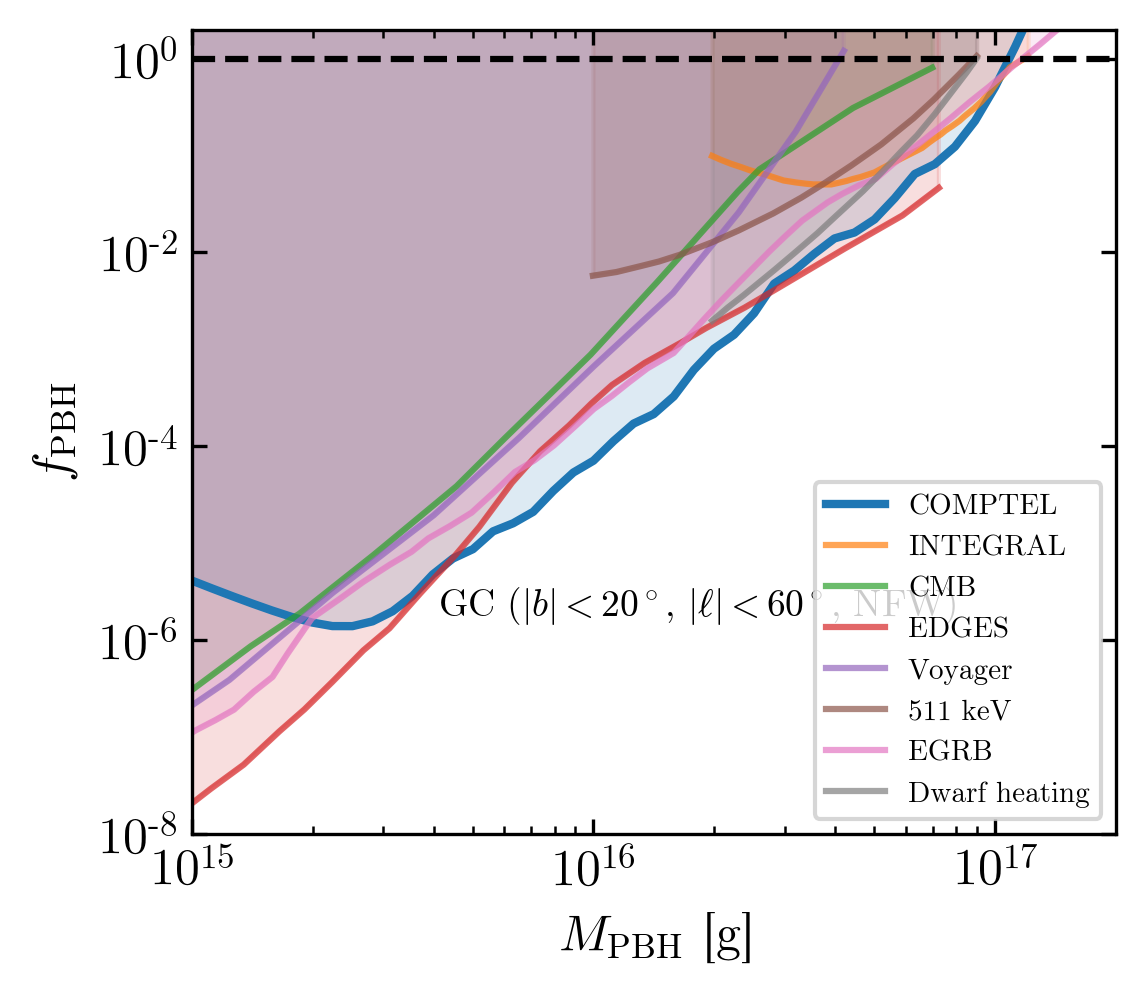

In [22]:
plt.figure(figsize=(4, 3.5))

bounds = [
    "INTEGRAL", "CMBevap", "EDGESevap", "Voyager", "511keV", "EGRB_full", "LeoTevap"
]

plt.fill_between(
    m_pbhs, f_pbh_constraints["comptel_nfw"], 1000,
    color=telescope_colors["comptel"], alpha=0.15
)
plt.loglog(
    m_pbhs, f_pbh_constraints["comptel_nfw"], label="COMPTEL",
    color=telescope_colors["comptel"], linewidth=2
)

plot_bounds(
    bounds, plt.gca(), colors=mpl_colors[1:],
    labels=[
        "INTEGRAL", "CMB", "EDGES", "Voyager", "511 keV", "EGRB", "Dwarf heating"
    ]
)

plt.text(4.1e15, 1.8e-6, r"GC ($|b| < 20^\circ$, $|\ell| < 60^\circ$, NFW)", fontsize=9)

plt.xlabel(r"$M_\mathrm{PBH}$ [g]")
plt.ylabel(r"$f_\mathrm{PBH}$")
plt.axhline(1, color="k", linestyle="--")
plt.xlim(1e15, 2e17)
plt.ylim(1e-8, 2)
plt.xscale("log")
plt.yscale("log")
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().tick_params(axis='both', which='both', direction="in")
plt.legend(fontsize=7)

plt.tight_layout()

if pbh.spectrum_kind == "secondary" and not pbh.bh_secondary:
    plt.savefig("figures/pbh_bounds_comptel.pdf")
elif pbh.spectrum_kind == "primary":
    plt.savefig("figures/pbh_bounds_comptel_primary.pdf")
else:
    plt.savefig("figures/pbh_bounds_comptel_bh.pdf")

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


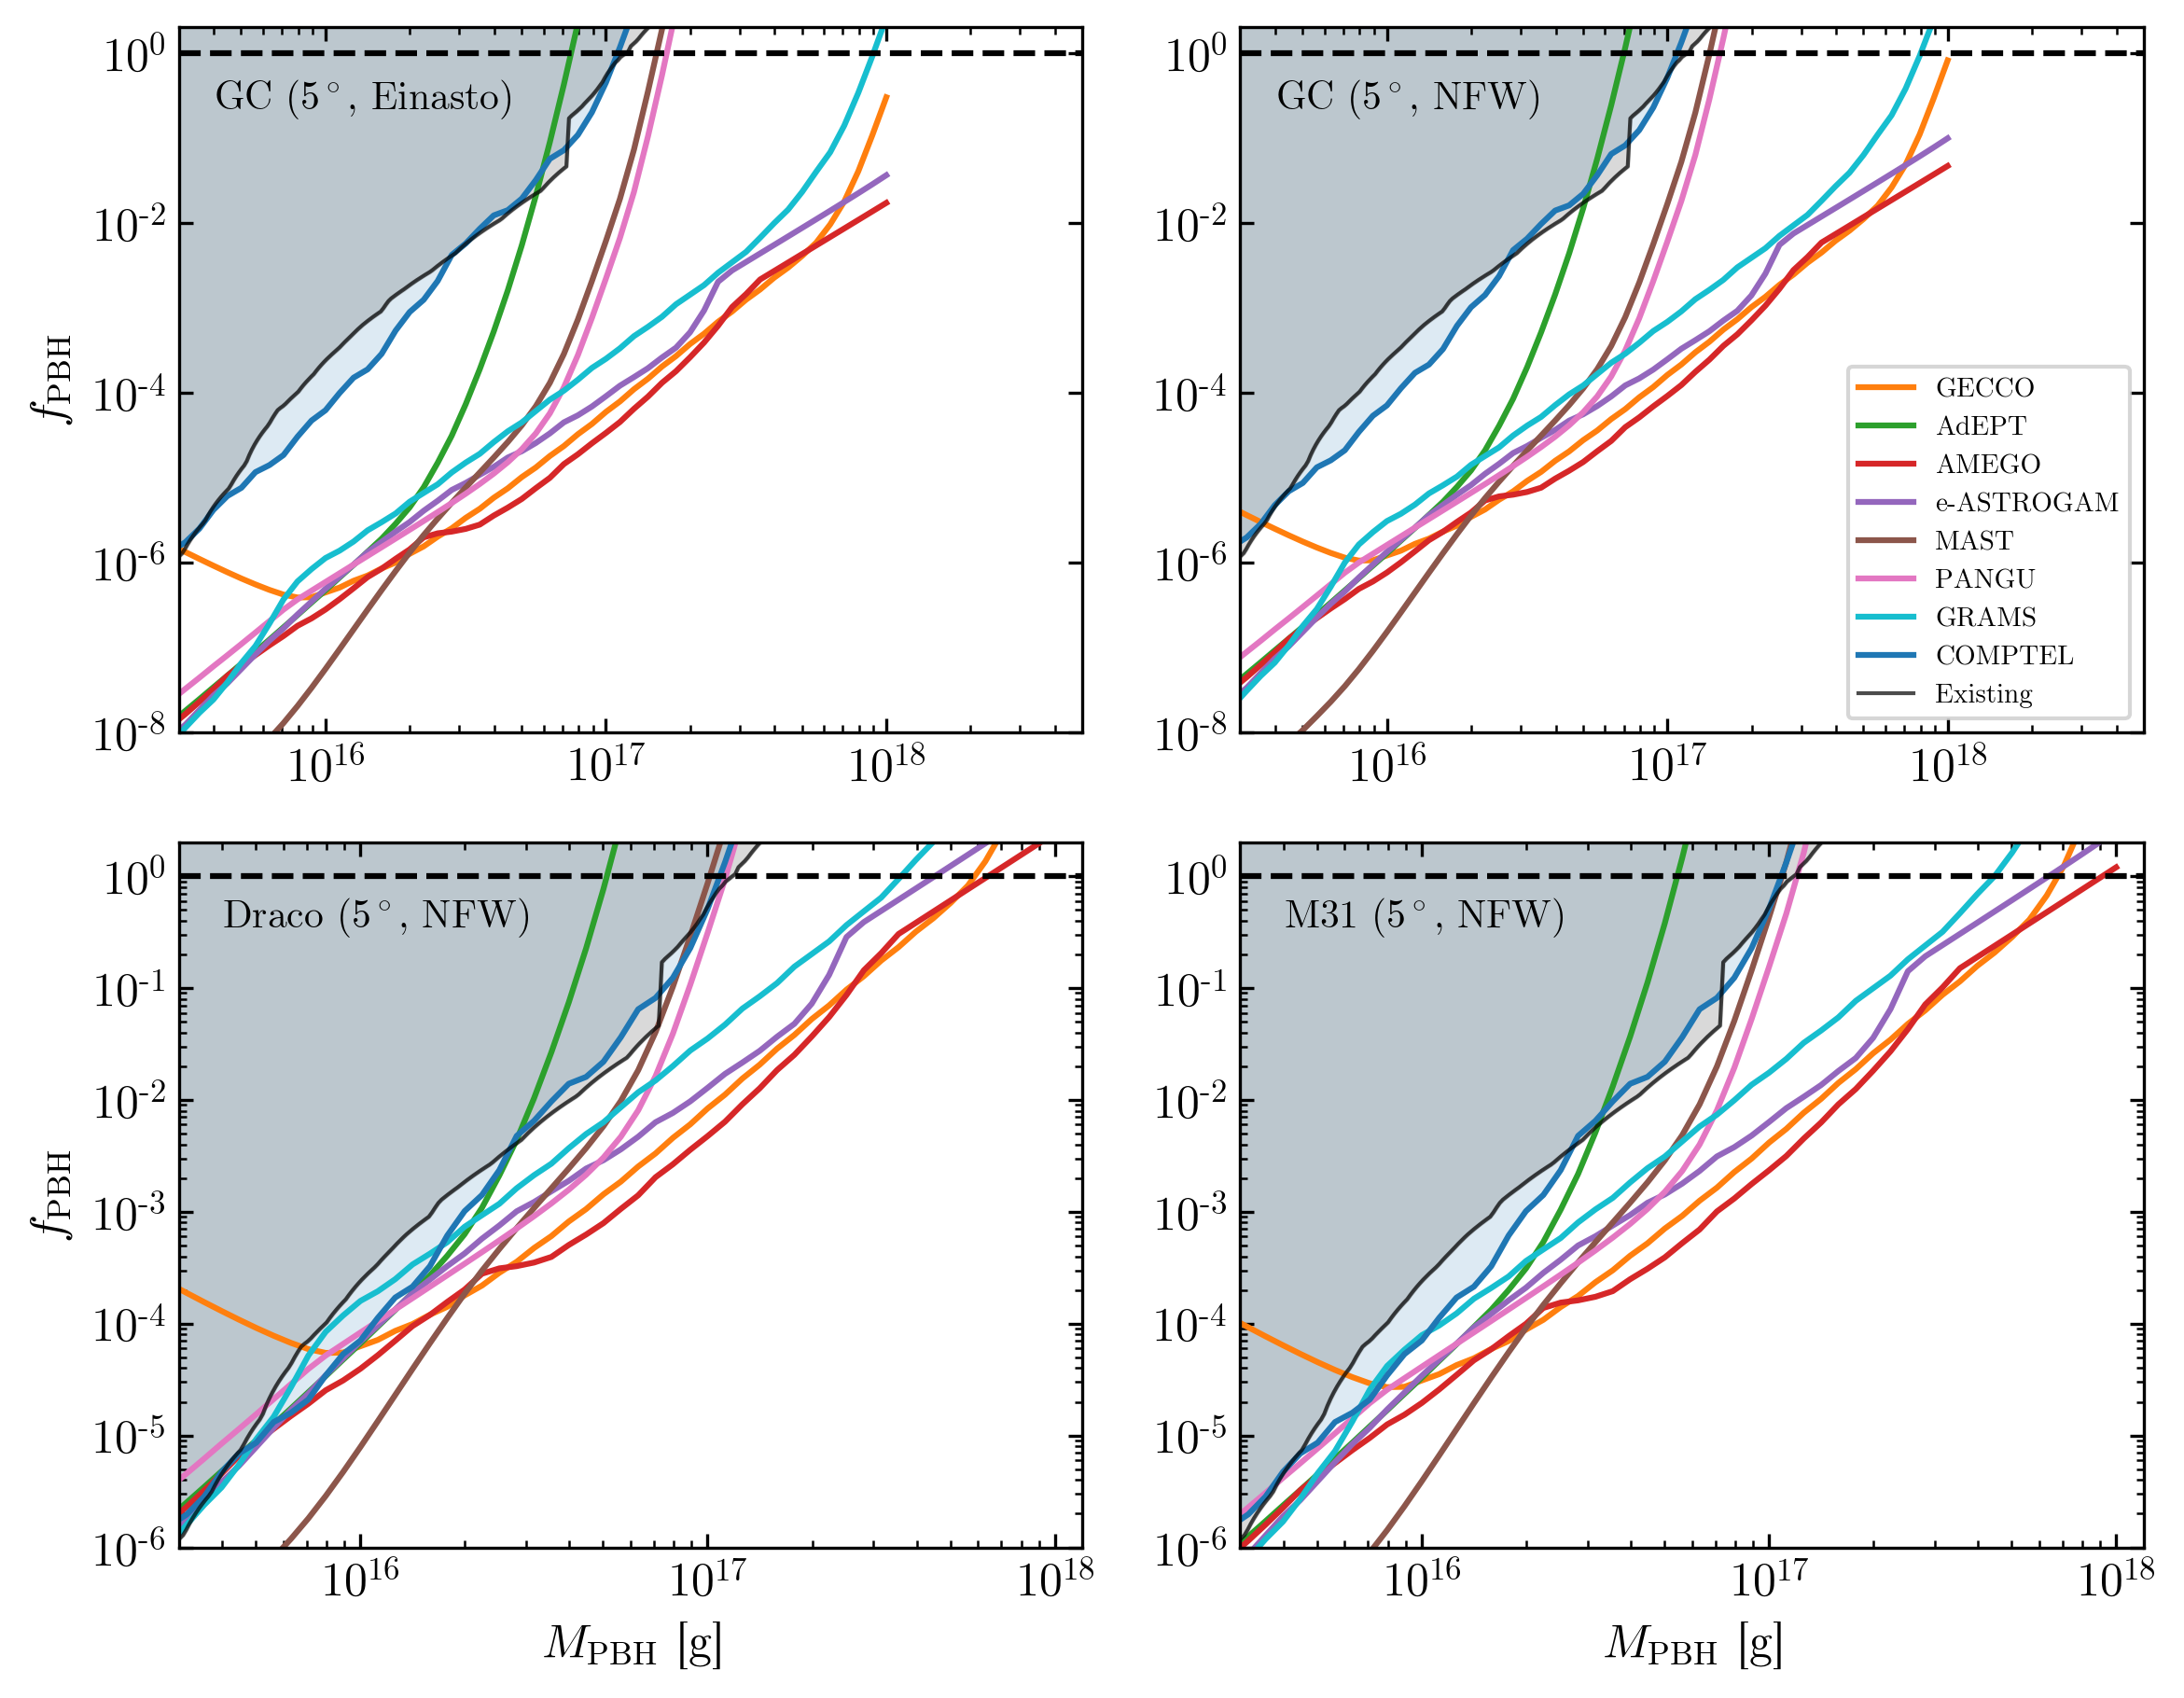

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6.25))

# GC (Ein)
ax = axes[0, 0]
for key, f_pbhs in f_pbh_constraints.items():
    if "gc_ein" in key:
        telescope = get_constraint_label(key).split(" ")[0]
        ax.loglog(
            m_pbhs, f_pbhs, telescope_colors[telescope.lower()],
            linewidth=1.5, label=telescope
        )

ax.fill_between(
    m_pbhs, f_pbh_constraints["comptel_ein"], 1000,
    color=telescope_colors["comptel"], alpha=0.15
)
ax.loglog(
    m_pbhs, f_pbh_constraints["comptel_ein"], label="COMPTEL",
    color=telescope_colors["comptel"], linewidth=1.5
)

# GC (NFW)
ax = axes[0, 1]
for key, f_pbhs in f_pbh_constraints.items():
    if "gc_nfw" in key:
        telescope = get_constraint_label(key).split(" ")[0]
        ax.loglog(
            m_pbhs, f_pbhs, telescope_colors[telescope.lower()],
            linewidth=1.5, label=telescope
        )

# Draco
ax = axes[1, 0]
for key, f_pbhs in f_pbh_constraints.items():
    if "draco" in key:
        telescope = get_constraint_label(key).split(" ")[0]
        ax.loglog(
            m_pbhs, f_pbhs, telescope_colors[telescope.lower()],
            linewidth=1.5, label=telescope
        )

# M31
ax = axes[1, 1]
for key, f_pbhs in f_pbh_constraints.items():
    if "m31" in key:
        telescope = get_constraint_label(key).split(" ")[0]
        ax.loglog(
            m_pbhs, f_pbhs, telescope_colors[telescope.lower()],
            linewidth=1.5, label=telescope
        )

# COMPTEL (NFW)
for ax in axes.flatten()[1:]:
    ax.fill_between(
        m_pbhs, f_pbh_constraints["comptel_nfw"], 1000,
        color=telescope_colors["comptel"], alpha=0.15
    )
    ax.loglog(
        m_pbhs, f_pbh_constraints["comptel_nfw"], label="COMPTEL",
        color=telescope_colors["comptel"], linewidth=1.5
    )

# Target labels
axes[0, 0].text(4e15, 2.2e-1, r"GC ($5^\circ$, Einasto)", fontsize=10)
axes[0, 1].text(4e15, 2.2e-1, r"GC ($5^\circ$, NFW)", fontsize=10)
axes[1, 0].text(4e15, 3.5e-1, r"Draco ($5^\circ$, NFW)", fontsize=10)
axes[1, 1].text(4e15, 3.5e-1, r"M31 ($5^\circ$, NFW)", fontsize=10)

# Formatting
for ax in axes.flatten():
    plot_bounds_envelope(bounds, ax, color="k", linewidth=1, label="Existing")
    ax.axhline(1, color="k", linestyle="--")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    ax.tick_params(axis='both', which='both', direction="in")

for ax in axes[0, :]:
    ax.set_xlim(3e15, 5e18)
    ax.set_ylim(1e-8, 2)

for ax in axes[1, :]:
    ax.set_xlim(3e15, 1.2e18)
    ax.set_ylim(1e-6, 2)
    ax.set_xlabel(r"$M_\mathrm{PBH}$ [g]")

for ax in axes[:, 0]:
    ax.set_ylabel(r"$f_\mathrm{PBH}$")

axes[0, 1].legend(fontsize=7)
fig.tight_layout()

if pbh.spectrum_kind == "secondary" and not pbh.bh_secondary:
    fig.savefig("figures/pbh_bounds_T=1e8s.pdf")
elif pbh.spectrum_kind == "primary":
    fig.savefig("figures/pbh_bounds_primary_T=1e8s.pdf")
else:
    fig.savefig("figures/pbh_bounds_bh_T=1e8s.pdf")

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


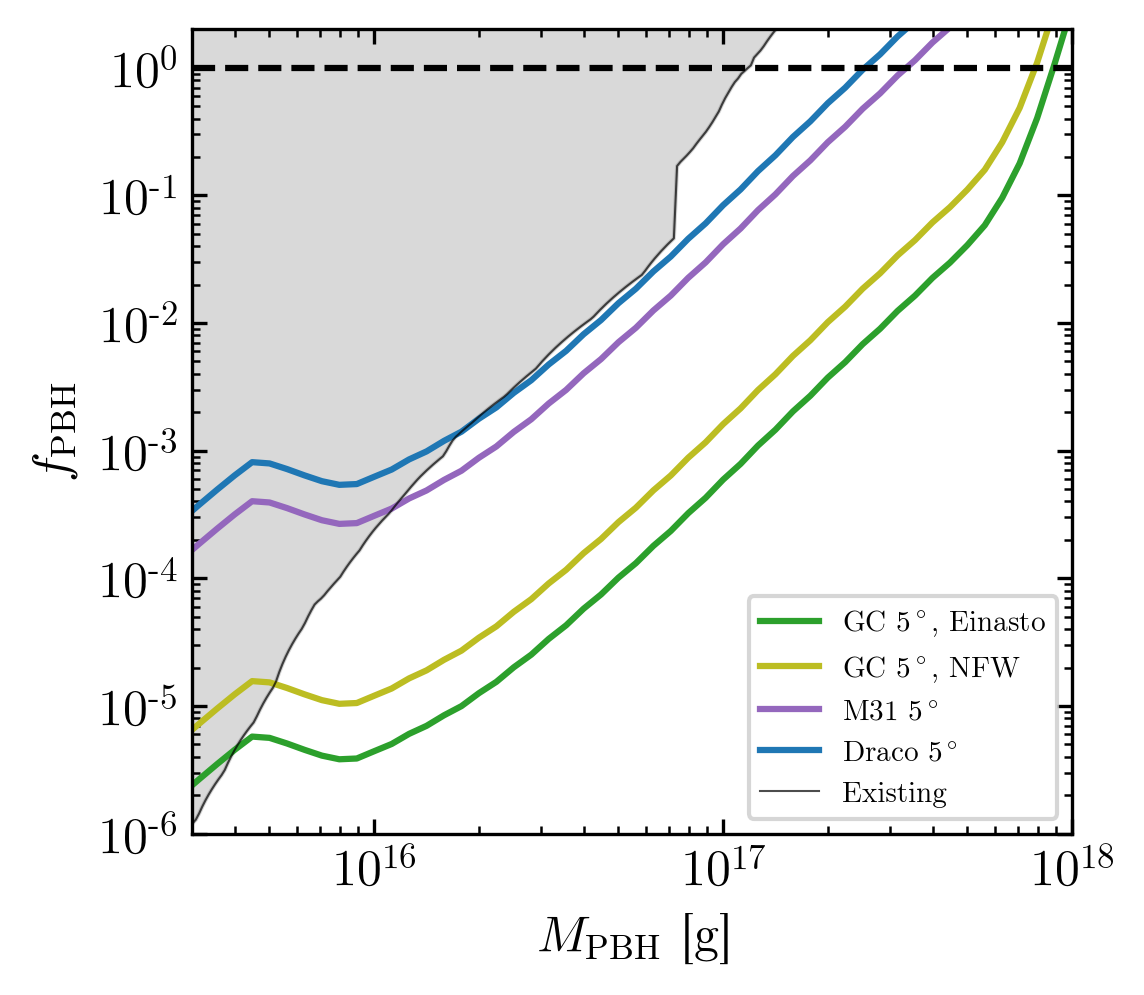

In [101]:
plt.figure(figsize=(4, 3.5))

for color, (key, f_pbhs) in zip(cycle(mpl_colors), f_pbh_constraints.items()):
    if "gecco" in key:
        plt.loglog(
            m_pbhs, f_pbhs, color=color,
            label=get_constraint_label(key).replace("GECCO (", "").replace(")", "")
        )

bounds = [
    "INTEGRAL", "CMBevap", "EDGESevap", "Voyager", "511keV", "EGRB_full", "LeoTevap"
]
# plot_bounds(
#     bounds, plt.gca(), labels=[
#         "INTEGRAL", "CMB", "EDGES", "Voyager", "511 keV", "EGRB", "Dwarf heating"
#     ]
# )
plot_bounds_envelope(bounds, plt.gca(), linewidth=0.5, label="Existing")

plt.xlabel(r"$M_\mathrm{PBH}$ [g]")
plt.ylabel(r"$f_\mathrm{PBH}$")
plt.axhline(1, color="k", linestyle="--")
plt.xlim(3e15, 1e18)
plt.ylim(1e-6, 2)
plt.xscale("log")
plt.yscale("log")
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().tick_params(axis='both', which='both', direction="in")
plt.legend(fontsize=7)#, bbox_to_anchor=(1, 0.5))

plt.tight_layout()

if pbh.spectrum_kind == "secondary" and not pbh.bh_secondary:
    plt.savefig("figures/pbh_bounds_gecco.pdf")
elif pbh.spectrum_kind == "primary":
    plt.savefig("figures/pbh_bounds_gecco_primary.pdf")
else:
    plt.savefig("figures/pbh_bounds_gecco_bh.pdf")

In [102]:
beep()

## Redoing constraints

In [26]:
pbh = PBH(1e15 * g_to_MeV, spectrum_kind="secondary", bh_secondary=False)

## Spectrum sanity check

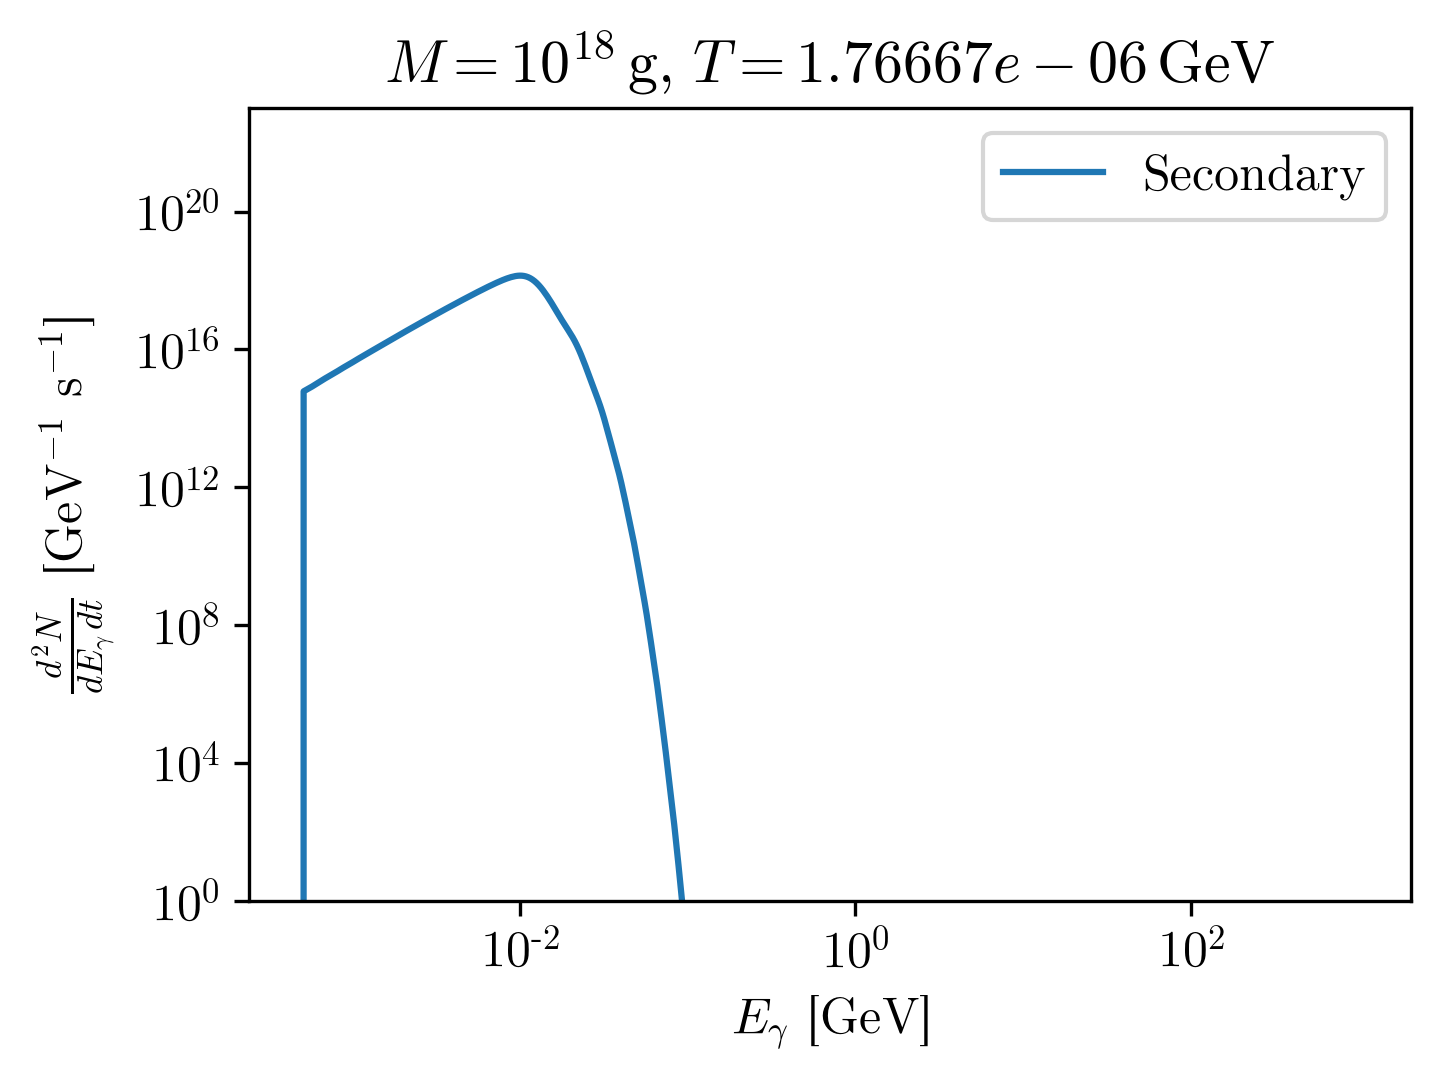

In [21]:
pbh_p = PBH(1e15 * g_to_MeV, spectrum_kind="primary")
pbh_bhs = PBH(1e15 * g_to_MeV, spectrum_kind="secondary", bh_secondary=True)
pbh_s = PBH(1e15 * g_to_MeV, spectrum_kind="secondary")

e_gams = np.geomspace(5e-4, 1000, 500)

# m_pbh = 1e15
pbh_s.mx = pbh_s._mxs[-1]
m_pbh = pbh_s.mx * MeV_to_g
plt.loglog(
    e_gams, pbh_s.total_spectrum(e_gams), label="Secondary",
)

try:
    pbh_bhs.mx = pbh_s.mx
    plt.loglog(
        e_gams, pbh_bhs.total_spectrum(e_gams), ":", label="BH secondary"
    )
except:
    pass

try:
    pbh_p.mx = pbh_s.mx
    plt.loglog(
        e_gams, pbh_p.total_spectrum(e_gams), "--", label="Primary"
    )
except:
    pass

# plt.xlim(e_gams[[0, -1]] * 1e-3)
plt.ylim(1e0, 1e23)
plt.xlabel(r"$E_\gamma$ [GeV]")
plt.ylabel(r"$\frac{d^2N}{dE_\gamma\, dt}$ [GeV$^{-1}$ s$^{-1}$]")
plt.title(r"$M=10^{%i}\, \mathrm{g},\, T = %g\, \mathrm{GeV}$" % (np.log10(m_pbh), 0.0106 / (m_pbh / 1e15)))
plt.legend()

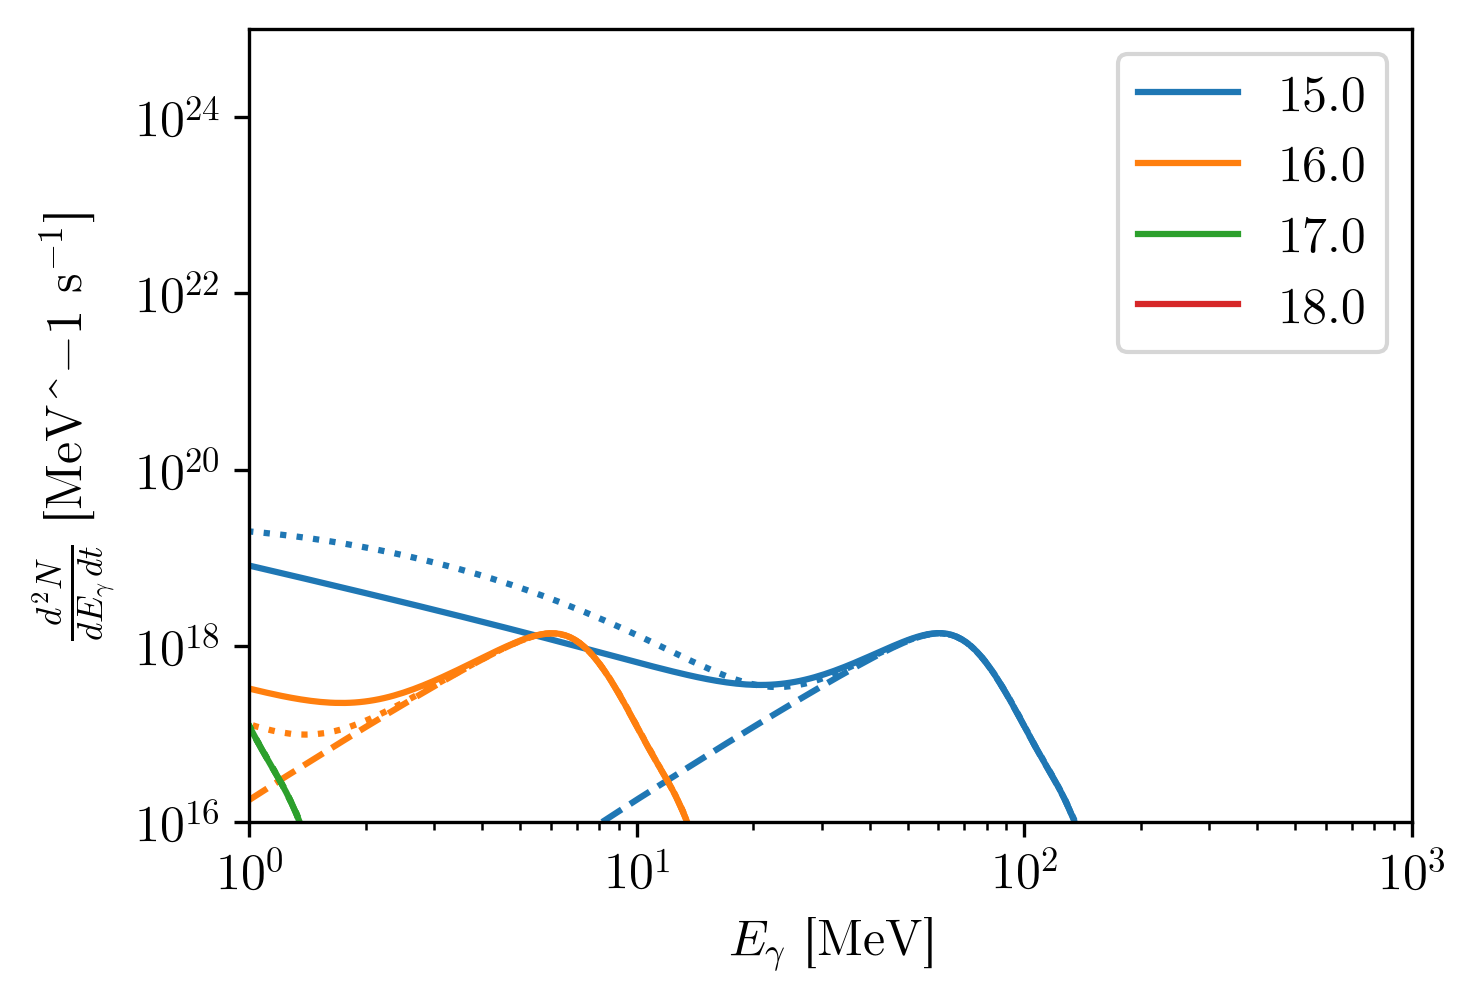

In [67]:
pbh_p = PBH(1e15 * g_to_MeV, spectrum_kind="primary")
pbh_bhs = PBH(1e15 * g_to_MeV, spectrum_kind="secondary", bh_secondary=True)
pbh_s = PBH(1e15 * g_to_MeV, spectrum_kind="secondary")

e_gams = np.geomspace(5e-4, 1000, 500)

mxs = np.geomspace(1e15, 1e18, 61) * g_to_MeV

for mx, color in zip(mxs[::20], mpl_colors):
    pbh_s.mx = mx
    plt.loglog(
        e_gams, pbh_s.total_spectrum(e_gams),
        color=color, label=np.log10(mx * MeV_to_g),
    )
    
    pbh_bhs.mx = mx
    plt.loglog(
        e_gams, pbh_bhs.total_spectrum(e_gams), ":", color=color,
    )
    
    pbh_p.mx = mx
    plt.loglog(
        e_gams, pbh_p.total_spectrum(e_gams), "--", color=color,
    )

# plt.xlim(e_gams[[0, -1]])
plt.xlim(1e0, 1e3)
plt.ylim(1e16, 1e25)
plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$\frac{d^2N}{dE_\gamma\, dt}$ [MeV^${-1}$ s$^{-1}$]")
plt.legend()

## NuSTAR limits

In [165]:
def energy_res_nustar(e_gam):
    e_a, res_a = 5e-3, 0.4 / 5
    e_b, res_b = 60e-3, 0.9 / 60
    
    def helper(e_gam):
        if e_gam < e_a:
            return res_a
        elif e_gam > e_b:
            return res_b
        else:
            return (e_gam - e_a) * (res_b - res_a) / (e_b - e_a) + res_a
    
    return np.vectorize(helper)(e_gam)

In [166]:
mxs_ns, Gammas_ns = np.loadtxt("data/nustar_limits.csv", unpack=True, delimiter=",")
mxs_ns *= 1e-3

In [168]:
nustar_constraints = np.zeros_like(pbh._mxs)

for i, mx in enumerate(pbh._mxs):
    pbh.mx = mx
    nustar_constraints[i] = min([
        Gamma_ns * pbh.mx / mx_ns / pbh.total_spectrum(mx_ns / 2)
        for mx_ns, Gamma_ns in zip(mxs_ns, Gammas_ns)
    ])

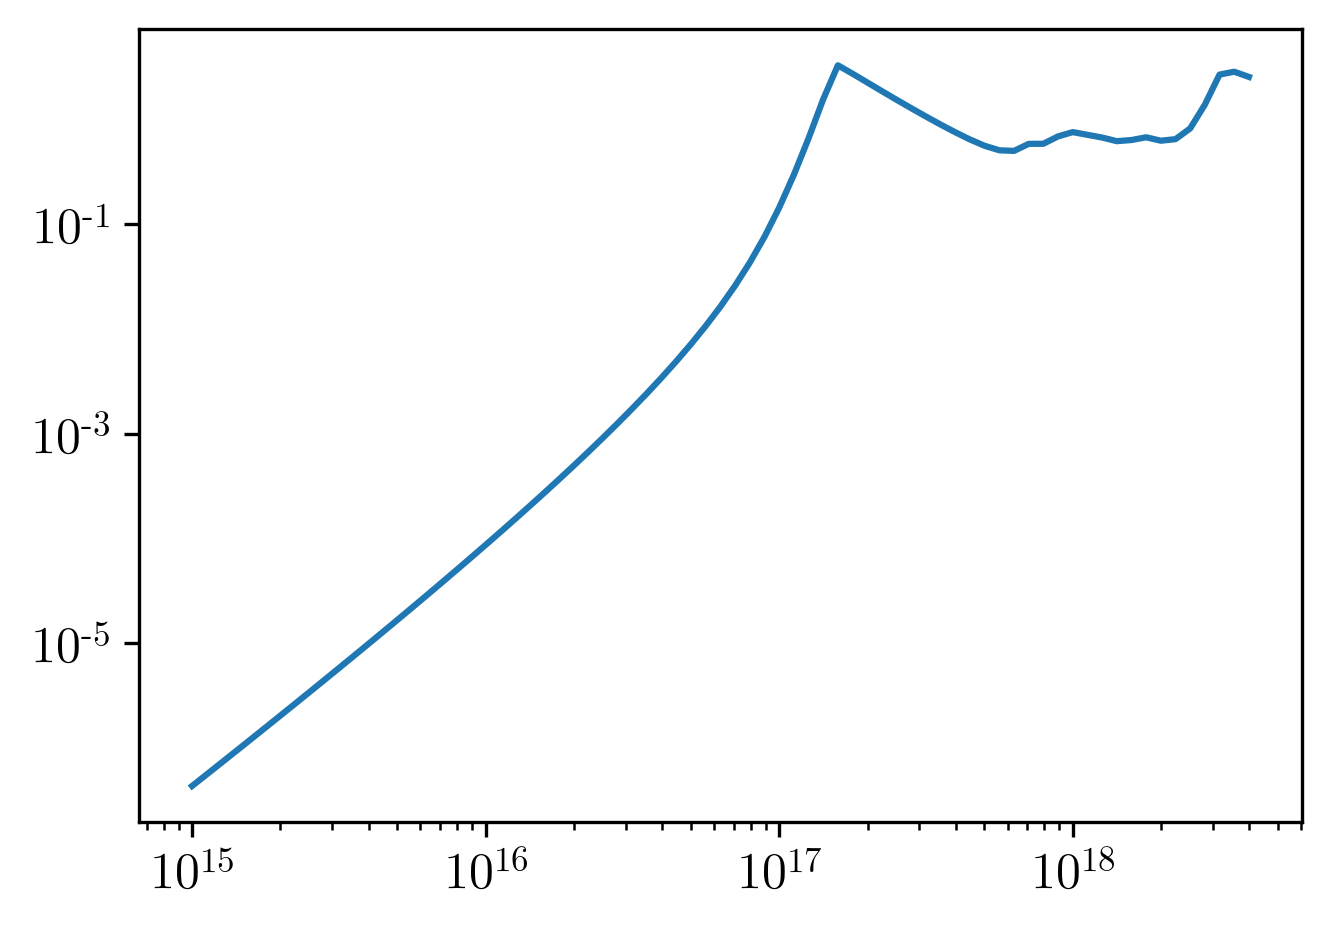

In [169]:
plt.loglog(pbh._mxs * MeV_to_g, nustar_constraints)

# Model-independent constraints

## Annihilation constraints

In [7]:
fss = ["e e", "g g", "mu mu", "pi pi"]
n_mxs = 100
mxs_light = np.geomspace(0.5, 250, n_mxs)
mxs_heavy = np.geomspace(60., 5e3, n_mxs)
mxs = {fs: mxs_light if fs in ["e e", "g g"] else mxs_heavy for fs in fss}

# For plotting
y_lims = {
    "e e": (1e-36, 1e-22),
    "g g": (1e-36, 1e-22),
    "mu mu": (1e-30, 1e-22),
    "pi pi": (1e-30, 1e-22),
    "pi0 pi0": (1e-30, 1e-22),
    "pi0 g": (1e-30, 1e-22),
}

In [8]:
sc_constraints = {}

for fs in fss:
    print("fs:", fs)
    model = SingleChannelAnn(1., fs, 1.)
    sc_constraints[fs] = get_constraints(model, mxs[fs])

fs: e e


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/theory/_theory_cmb.py:44: RuntimeWarning: divide by zero encountered in double_scalars
  return p_ann * self.mx / self.f_eff(x_kd)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:185: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


fs: g g
fs: mu mu
fs: pi pi


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:166: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


In [48]:
# # Save constraints
# np.savez("data/sv_constraints_single_channels.npz", **sc_constraints)

In [10]:
beep()

In [63]:
# # Unpack carefully...
# sc_constraints = dict(
#     np.load("data/sv_constraints_single_channels.npz", allow_pickle=True)
# )
# sc_constraints = {k: v.item() for k, v in sc_constraints.items()}

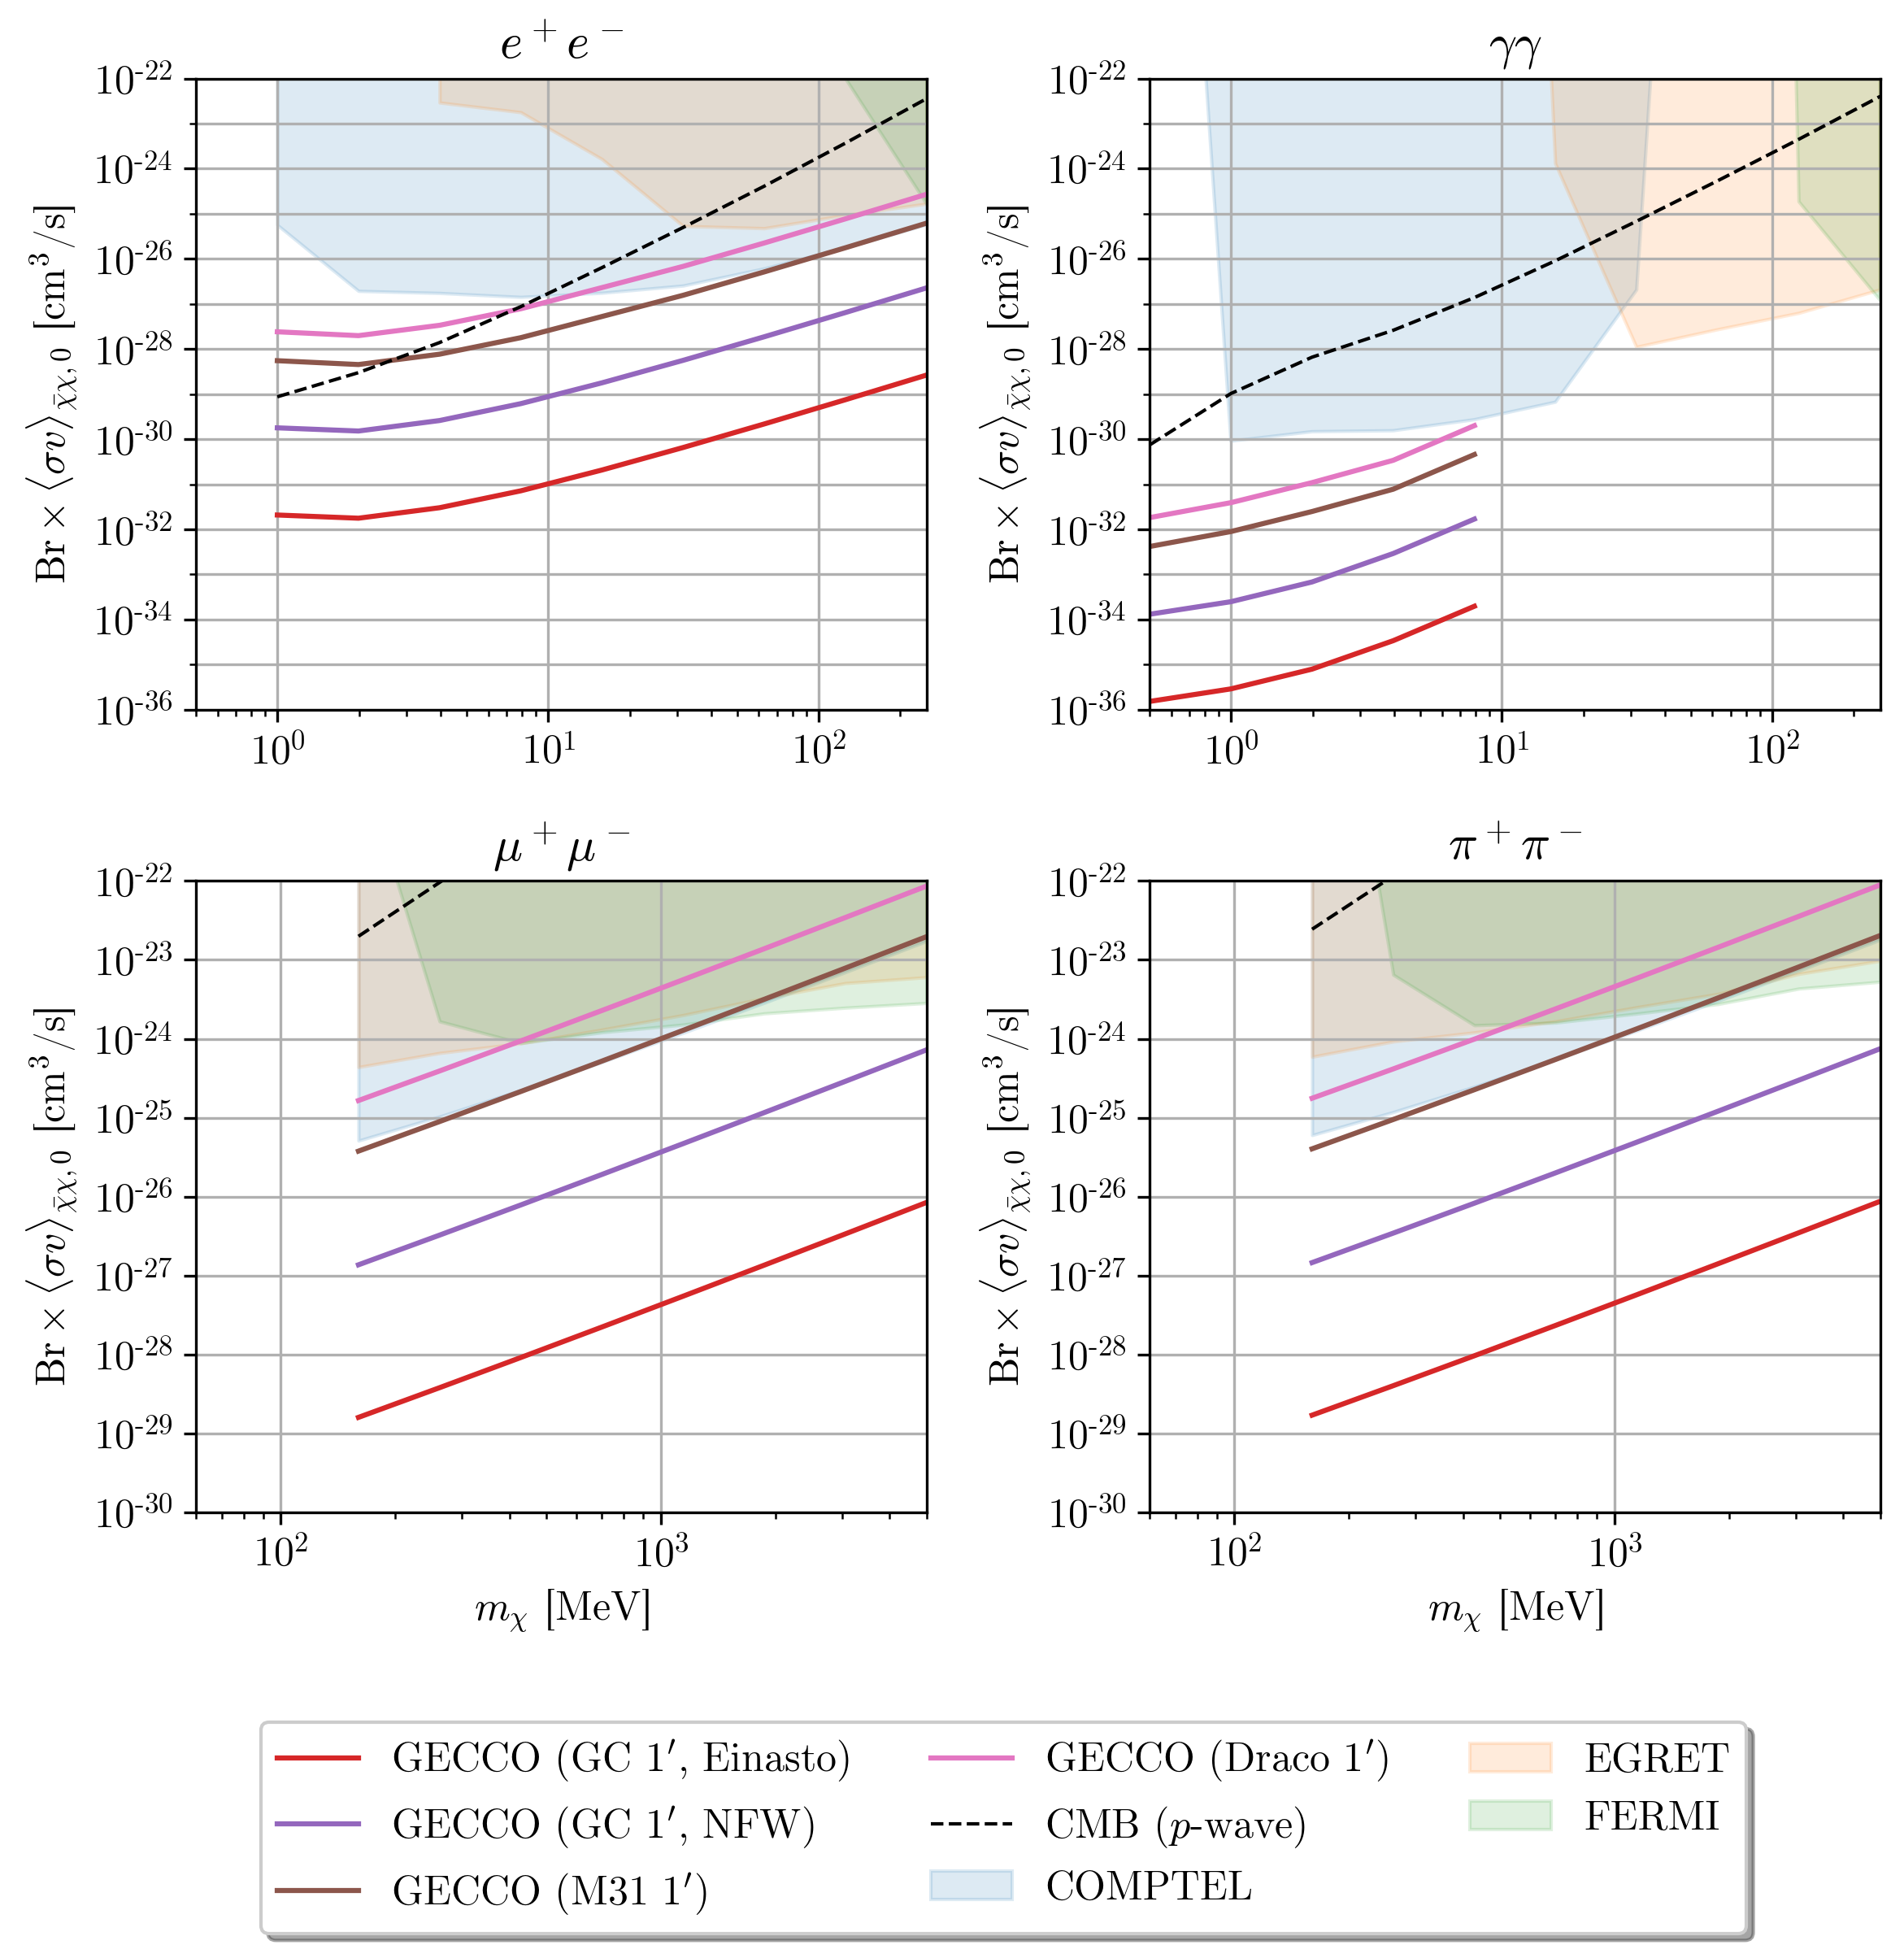

In [15]:
fig, axes = get_formatted_fig(2, 2, (4 * 2, 7), (0.5, 1e3), (1e-35, 1e-23))

for fs, ax in zip(fss, axes.flatten()):
    ax.set_title(get_fs_label(fs))
    ax.set_ylabel(
        r"$\mathrm{Br} \times \langle \sigma v \rangle_{\bar{\chi}\chi, 0}$ [cm$^3$/s]"
    )
    ax.set_xlim(mxs[fs][[0, -1]])
    ax.set_ylim(y_lims[fs])
    
    # Bradley and Cirelli's constraints
    # if fs in ["e e", "mu mu", "pi pi"]:
    #     mxs_integral, svs_integral = np.loadtxt(
    #         f"data/integral_{fs.replace(' ', '_')}.csv", unpack=True
    #     )
    #     ax.plot(mxs_integral, svs_integral, "--k")
    
    # This parameter is really weird. Just needs to be larger than the number
    # of ticks...
    n_minor_ticks = np.log10(y_lims["e e"][-1]) - np.log10(y_lims["e e"][0]) + 5
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=n_minor_ticks // 2 + 1))
    ax.yaxis.set_minor_locator(LogLocator(base=10, numticks=n_minor_ticks))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.grid(True, which='both')
    
    for color, (key, svs) in zip(colors, sc_constraints[fs].items()):
        if key == "cmb":
            # # s-wave
            # ax.plot(mxs[fs], svs, "-.k", linewidth=1, label=r"CMB ($s$-wave)")
            # p-wave
            v_cmbs = 2e-4 * (0.235) * (1 / mxs[fs]) * np.sqrt(1e-4 / x_kd)
            ax.plot(
                mxs[fs], svs * (v_mw / v_cmbs)**2, "--k", linewidth=1,
                label=r"CMB ($p$-wave)"
            )
        elif "gecco" not in key:
            # Existing constraints
            ax.fill_between(
                mxs[fs], svs, y2=1e-20, label=get_constraint_label(key), alpha=0.15,
                color=color
            )
            # ax.plot(
            #     mxs[fs], svs, "-", linewidth=0.75, label=get_constraint_label(key)
            # )
        else:
            ax.plot(mxs[fs], svs, label=get_constraint_label(key), color=color)

fig.tight_layout()

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.2, -0.3), fancybox=True, shadow=True, ncol=3
)

# fig.savefig("figures/gecco/single_channel_sigmav_limits.pdf", bbox_inches="tight")

## Decay constraints

This is a hack for now. The decaying DM's mass is equal to `2 mx`!

In [77]:
fss = ["e e", "g g", "mu mu", "pi pi"]
n_mxs = 100
mxs_light = np.geomspace(1, 1e3, n_mxs)
mxs_heavy = np.geomspace(1e2, 1e4, n_mxs)
mxs = {fs: mxs_light if fs in ["e e", "g g"] else mxs_heavy for fs in fss}

# For plotting
y_lims = {
    "e e": (1e22, 1e32),
    "g g": (1e22, 1e32),
    "mu mu": (1e22, 1e28),
    "pi pi": (1e22, 1e28),
}

In [78]:
sc_constraints = {}

for fs in fss:
    print("fs:", fs)
    model = SingleChannelDec(1., fs, 1.)
    sc_constraints[fs] = get_constraints(model, mxs[fs])

fs: e e


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:353: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)


fs: g g
fs: mu mu


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:53: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_muon.Spectrum(photon_energies, muon_energy)


fs: pi pi


/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/single_channel.py:334: RuntimeWarning: invalid value encountered in log
  * (np.log((1 - x) / mu ** 2) - 1)
/Users/acoogan/Physics/Sub-GeV_DM/Hazma/hazma/decay.py:141: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return decay_charged_pion.Spectrum(photon_energies, pion_energy, mode)


In [79]:
# Save constraints
np.savez("data/gamma_constraints_single_channels.npz", **sc_constraints)

In [80]:
beep()

In [23]:
# # Unpack carefully...
# sc_constraints = dict(
#     np.load("data/gamma_constraints_single_channels.npz", allow_pickle=True)
# )
# sc_constraints = {k: v.item() for k, v in sc_constraints.items()}

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


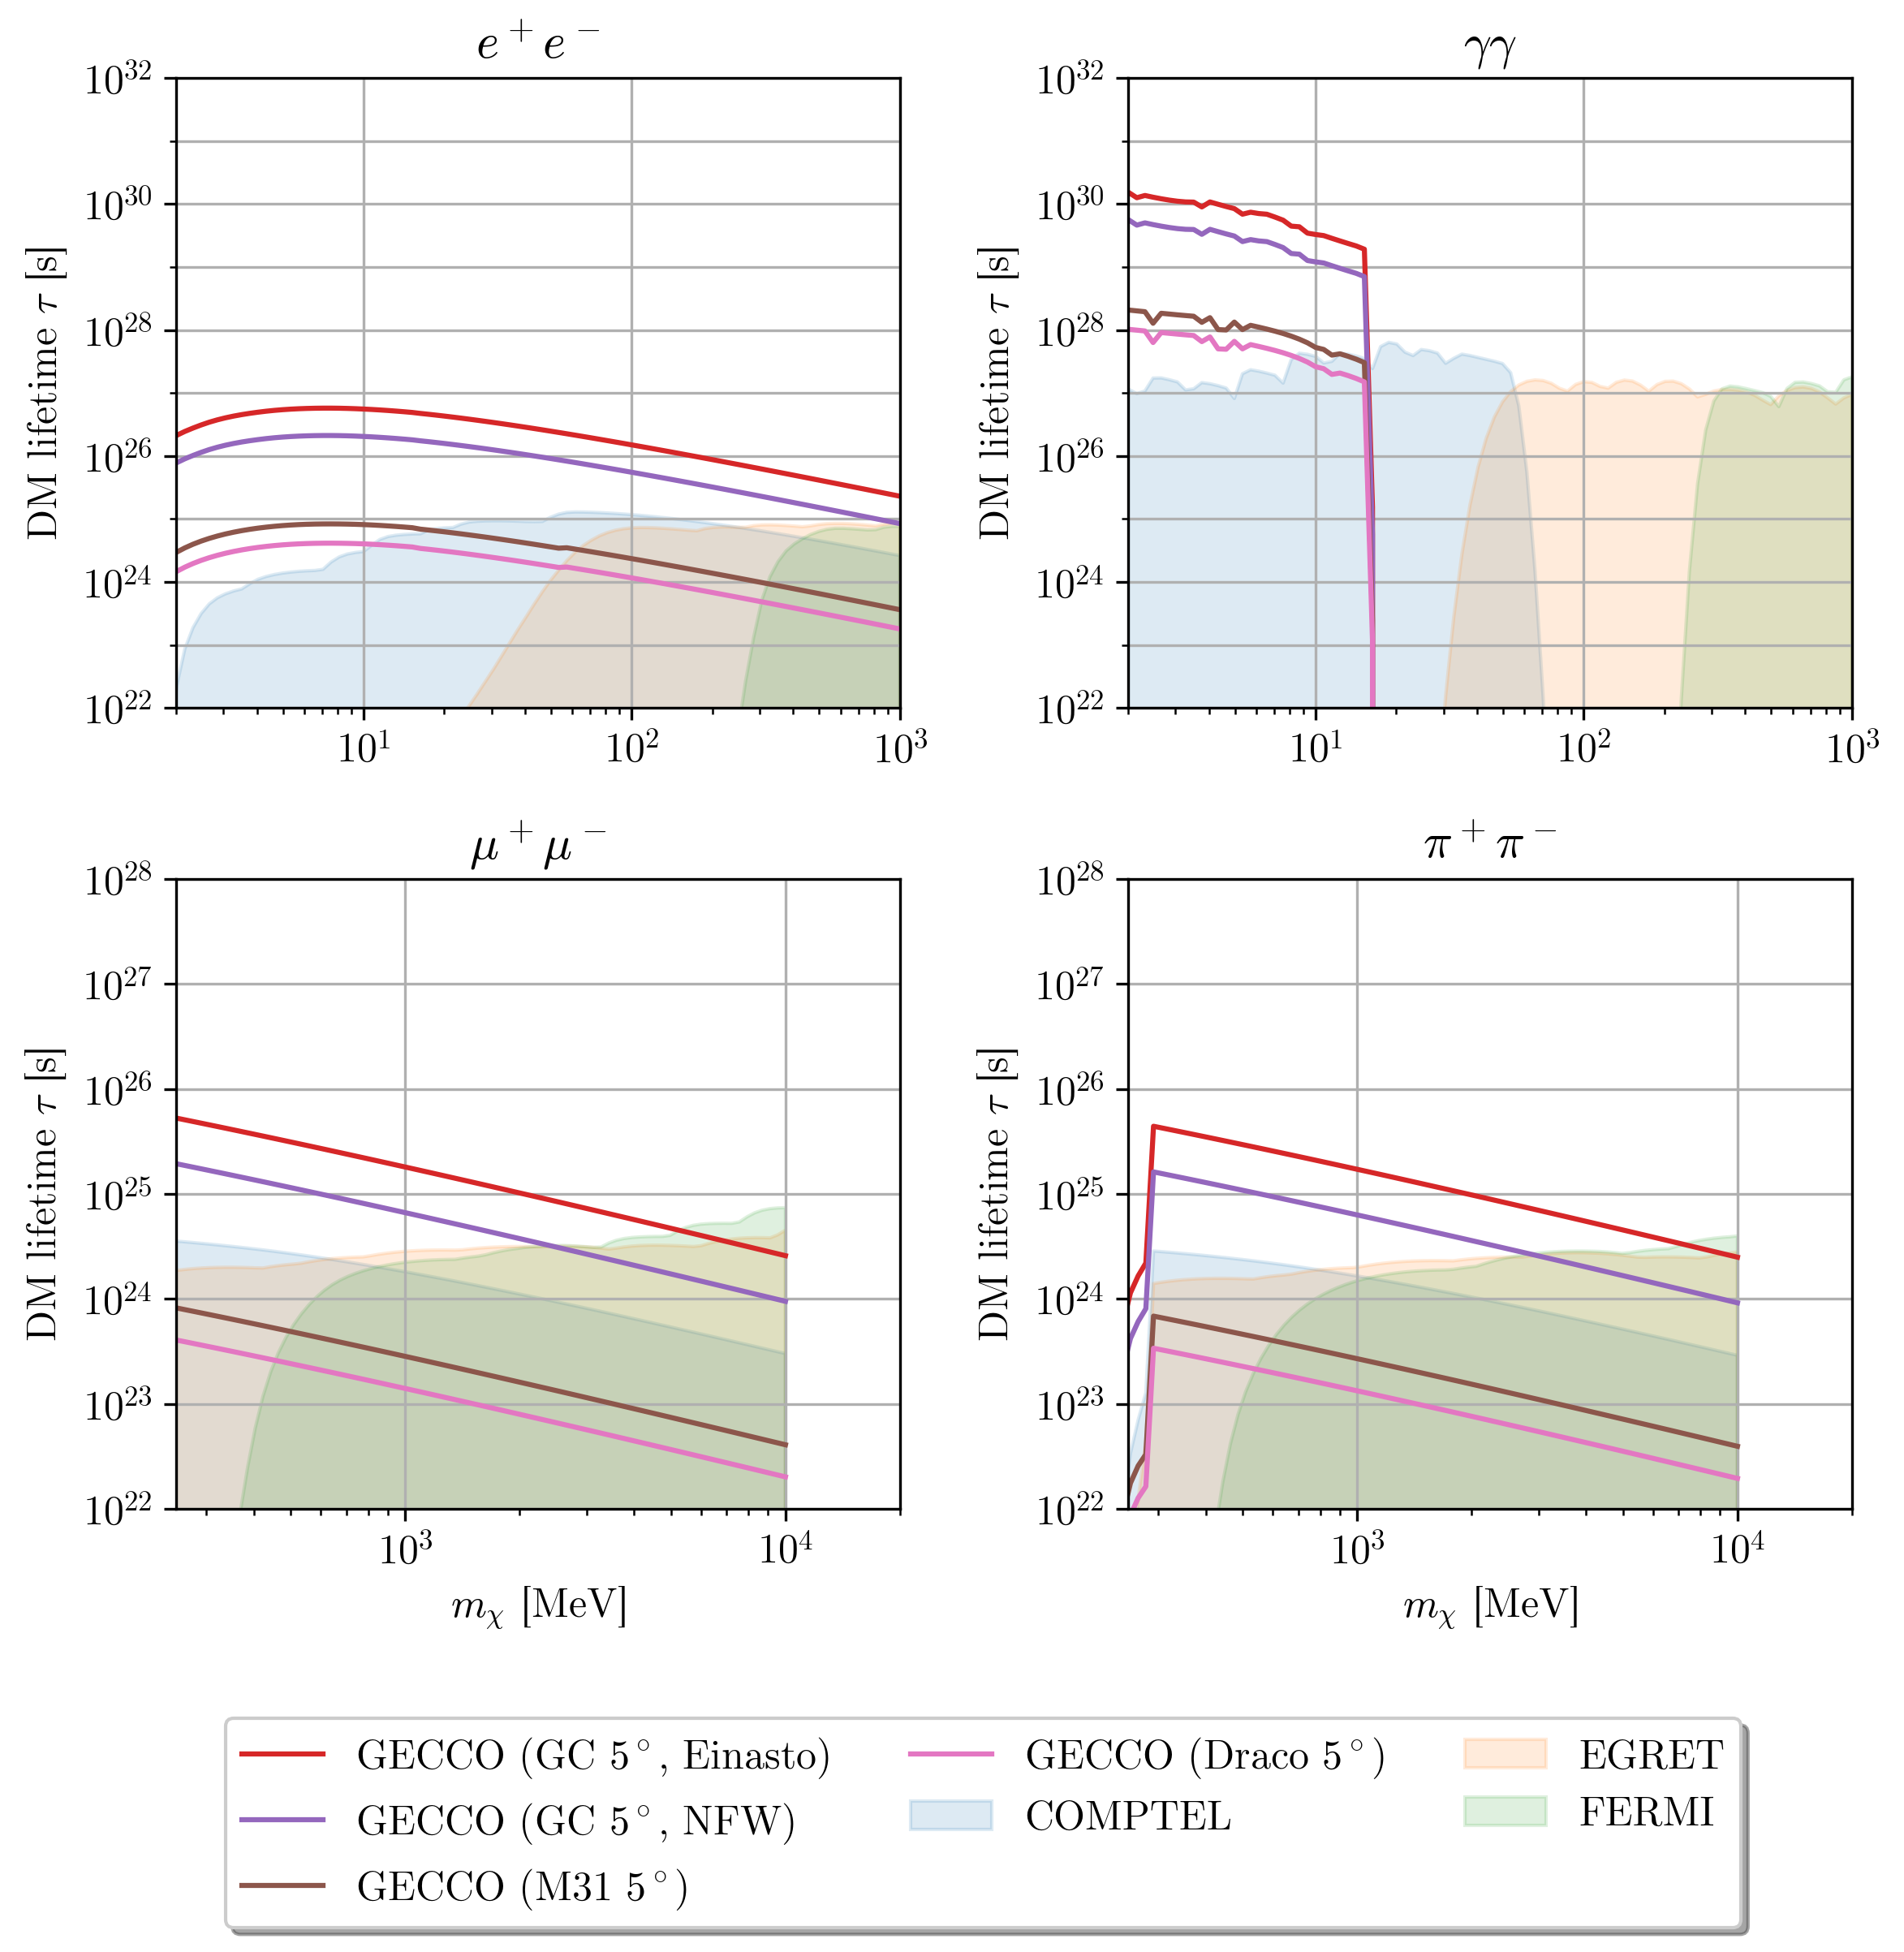

In [81]:
fig, axes = get_formatted_fig(2, 2, (4 * 2, 7), (0.5, 1e3), (1e20, 1e32))

for fs, ax in zip(fss, axes.flatten()):
    ax.set_title(get_fs_label(fs))
    ax.set_ylabel(r"DM lifetime $\tau$ [s]")
#     ax.set_xlim(mxs[fs][[0, -1]])
    ax.set_ylim(y_lims[fs])
    
    # This parameter is really weird. Just needs to be larger than the number
    # of ticks...
    n_minor_ticks = np.log10(y_lims["e e"][-1]) - np.log10(y_lims["e e"][0]) + 5
    ax.yaxis.set_major_locator(LogLocator(base=10, numticks=n_minor_ticks // 2 + 1))
    ax.yaxis.set_minor_locator(LogLocator(base=10, numticks=n_minor_ticks))
    ax.yaxis.set_minor_formatter(NullFormatter())
    ax.yaxis.grid(True, which='both')
    
    for color, (key, gamma) in zip(colors, sc_constraints[fs].items()):
        if key == "cmb":
            pass
        elif "gecco" not in key:
            # Existing constraints
            ax.fill_between(
                mxs[fs], 1 / gamma, y2=1e-20,
                label=get_constraint_label(key), alpha=0.15, color=color
            )
        else:
            ax.plot(mxs[fs], 1 / gamma, label=get_constraint_label(key), color=color)

fig.tight_layout()

for ax in axes[0]:
    ax.set_xlim(2, 1e3)

for ax in axes[1]:
    ax.set_xlim(2.5e2, 2e4)

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.2, -0.3), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/single_channel_lifetime_limits.pdf", bbox_inches="tight")

# Higgs portal model

## Pheno constraints

In [33]:
constr_gamma = sm.constrain_binned_gamma(
    "ms", mss, "stheta", sthetas, egret_diffuse,# "image"
)

NameError: name 'sm' is not defined

In [18]:
plt.contourf(
    mss, sthetas, constr_gamma, levels=[-1e100, 0], colors=[color],
    linewidths=[1], alpha=0.3
)

# plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$m_S$ [MeV]")
plt.ylabel(r"$\sin \theta$")
# plt.legend()
plt.title(r"$m_\chi = %i$ MeV" % sm.mx)

NameError: name 'constr_gamma' is not defined

In [87]:
sm = HiggsPortal(mx=200, ms=1e3, gsxx=1., stheta=0.1)
mss = np.linspace(100, 1e3, 60)
sthetas = np.geomspace(1e-5, 1e0, 50)

In [88]:
constrs = sm.constrain("ms", mss, "stheta", sthetas, "image")

In [110]:
def get_constr_label(name):
    name = f"${name}$"
    label = name.replace("->", "\\to")
    label = label.replace("e e", "e^+ e^-")
    label = label.replace("mu mu", "\mu^+ \mu^-")
    label = label.replace(" pi0", " \pi^0")
    label = label.replace(" pi", " \pi")
    label = label.replace("k ", "K ")
    label = label.replace("kl ", "K_L ")
    label = label.replace(" invis", "\, \mathrm{invis.}")
    label = label.replace("charm", "\mathrm{CHARM}")
    return label

/Users/acoogan/.pyenv/versions/miniconda3-latest/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: linewidths is ignored by contourf
  after removing the cwd from sys.path.


Text(0.5, 1.0, '$m_\\chi = 200$ MeV')

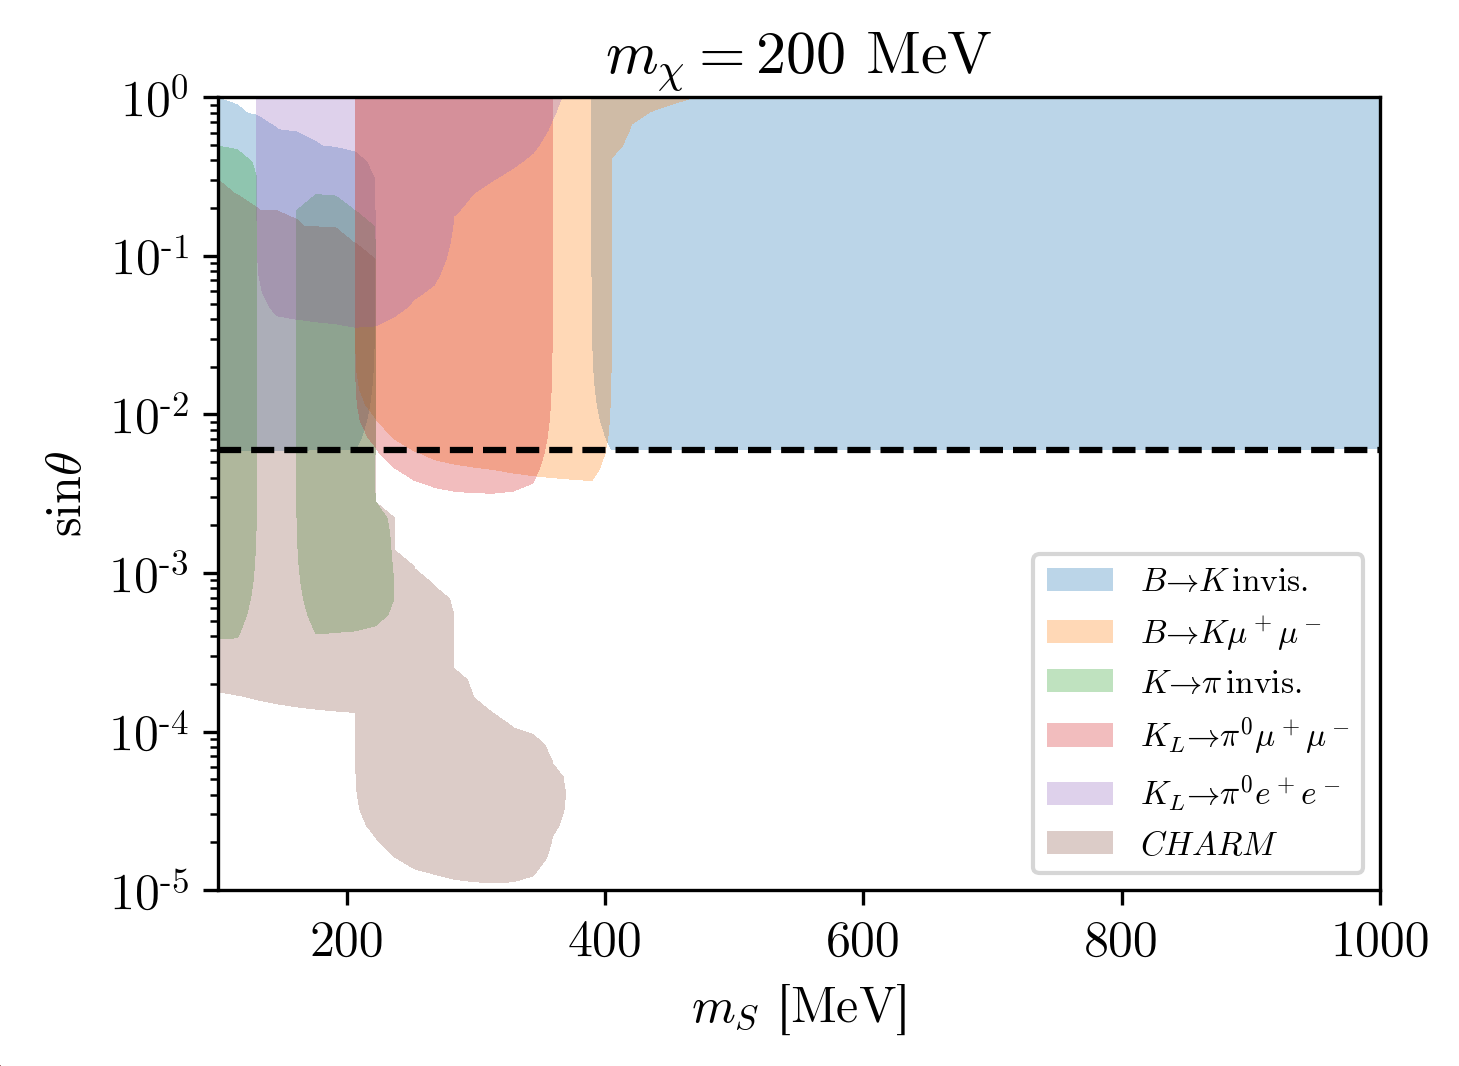

In [113]:
for (name, constr), color in zip(constrs.items(), colors):
    plt.contourf(
        mss, sthetas, constr, levels=[-1e100, 0], colors=[color], linewidths=[1],
        alpha=0.3
    )
    proxy = plt.Rectangle(
        (0, 0), 1, 1, fc=color, label=get_constr_label(name), alpha=0.3
    )
    plt.gca().patches += [proxy]

plt.axhline(6e-3, color="k", linestyle="--")

plt.yscale("log")
plt.xlabel(r"$m_S$ [MeV]")
plt.ylabel(r"$\sin \theta$")
plt.legend(fontsize=8, loc="lower right")
plt.title(r"$m_\chi = %i$ MeV" % sm.mx)

## Gamma-ray constraints

In [162]:
mxs = np.geomspace(0.5, 250, 20)
mss = mxs / 3

sm_args = np.array([[{"mx": 1., "ms": 1., "gsxx": 1., "stheta": 0.1}]])
SMs = np.array([[HiggsPortal]])
# Instantiate all the models
sms = np.vectorize(lambda SM, kwargs: SM(**kwargs))(SMs, sm_args)

In [163]:
def set_m_med(sm, ms):
    sm.ms = ms

In [164]:
# Recompute constraints
sv_constraints_sms = np.empty_like(sms)
for i in range(len(sms)):
    for j in range(len(sms[i])):
        sv_constraints_sms[i, j] = get_constraints(
            sms[i, j], mxs, set_m_med, m_meds=mss
        )

# Save results
# np.savez(
#     "data/sv_constraints_sms.npz", sv_constraints_sms=sv_constraints_sms, sm_args=sm_args
# )

# sv_constraints_sms = np.load(
#     "data/sv_constraints_sms.npz", allow_pickle=True
# )["sv_constraints_sms"]

In [165]:
def get_svs(model, mxs, stheta, vx=1e-3, mss=None):
    svs = []
    for i in range(len(mxs)):
        model.stheta = 6e-3
        model.mx = mxs[i]
        if mss is not None:
            model.ms = mss[i]
        sv = model.annihilation_cross_sections(
            2 * model.mx * (1 + 0.5 * vx**2)
        )["total"] * vx
        svs.append(sv * sv_inv_MeV_to_cm3_per_s)
    return np.array(svs)

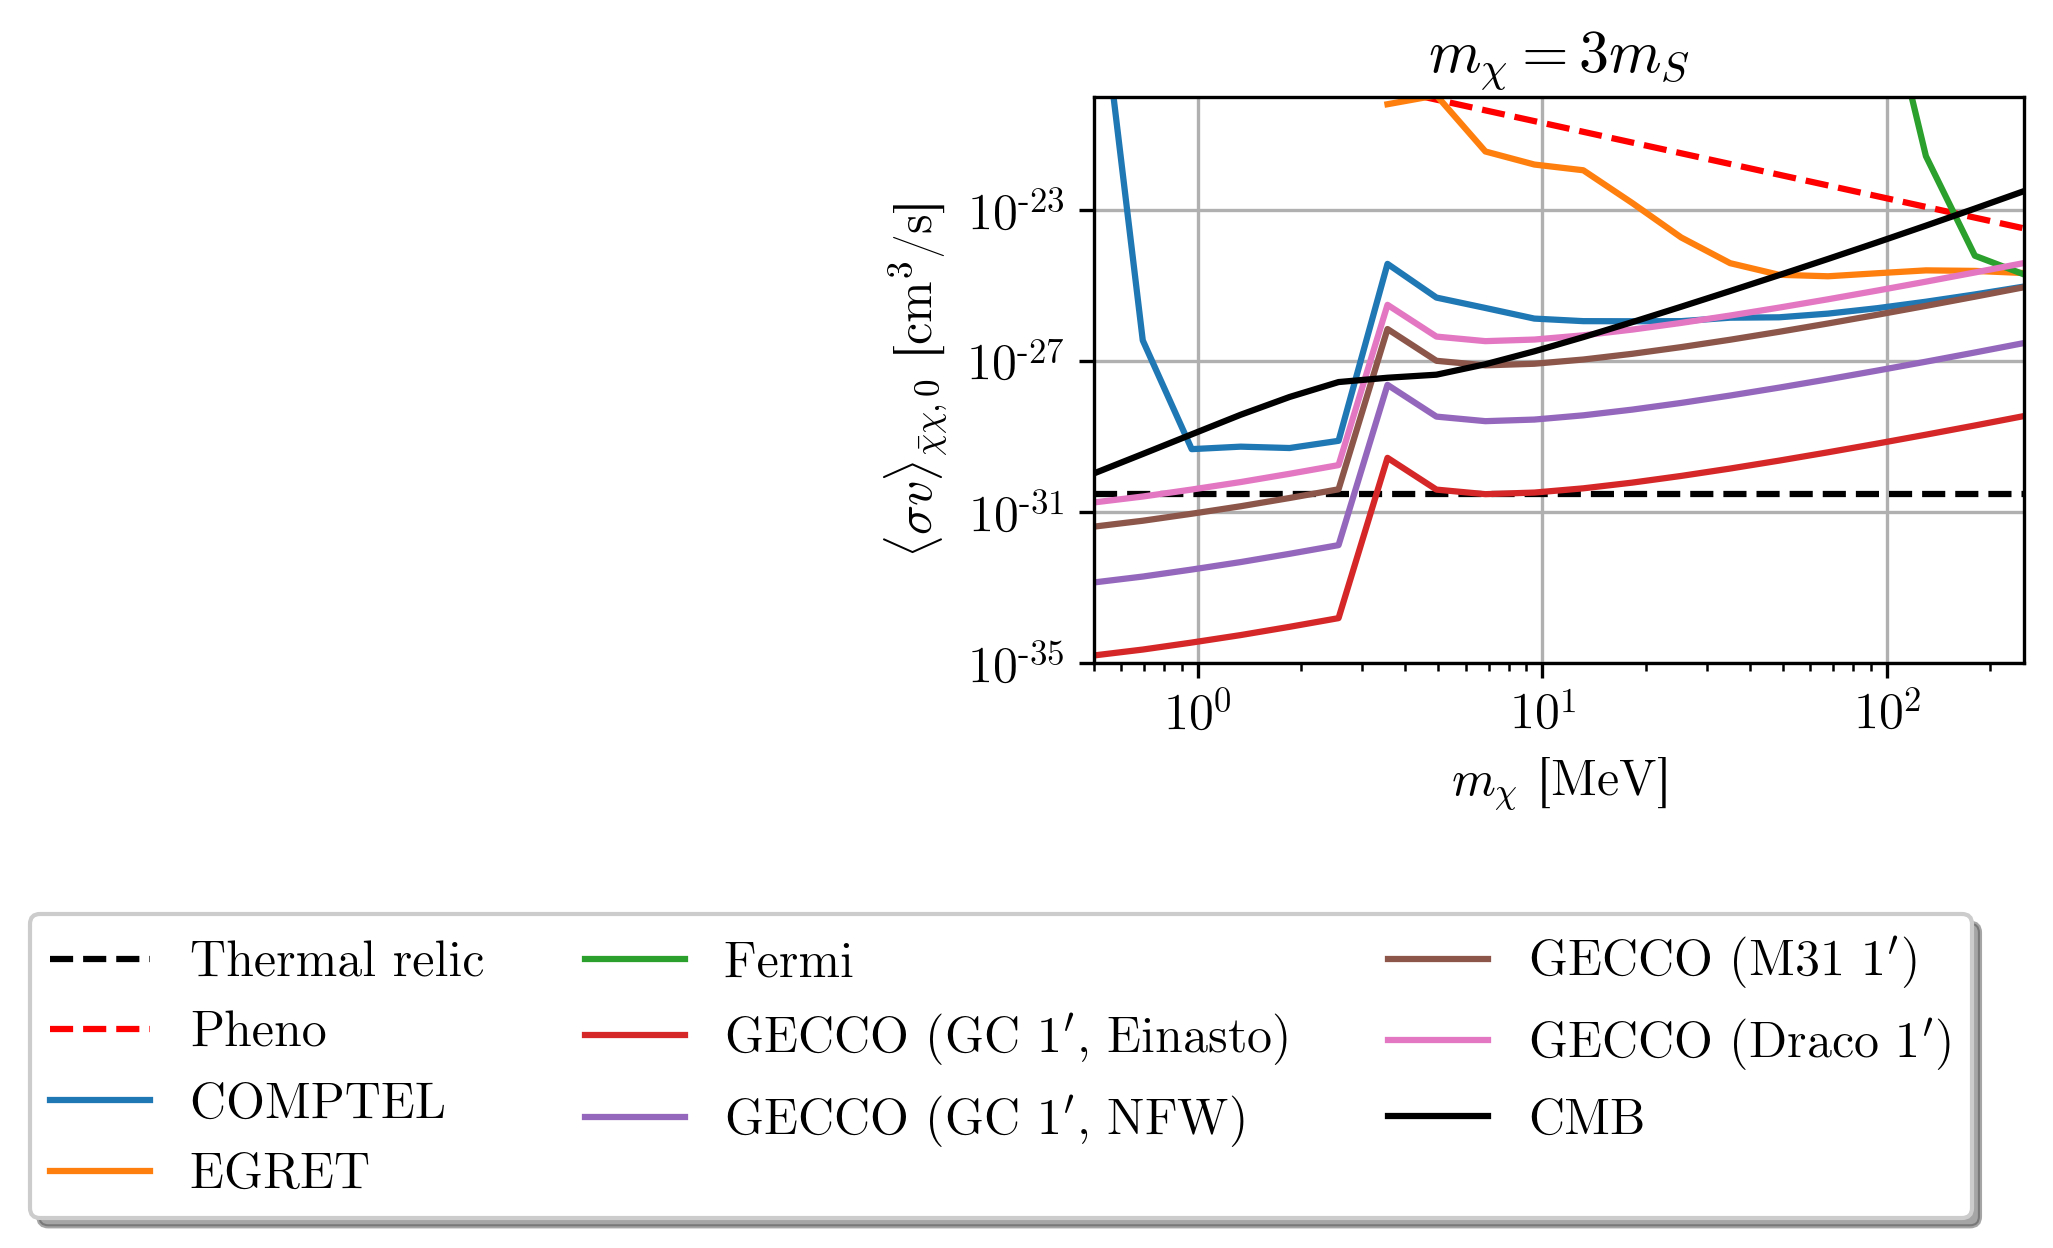

In [168]:
fig, axes = get_formatted_fig(
    *sms.shape, (4 * sms.shape[1], 2.5 * sms.shape[0]),
    mxs[[0, -1]], (1e-35, 1e-20)
)

stheta_pheno = 6e-3

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Relic cross section tranlated to <sigma v> in the Milky Way
        v_fo = np.sqrt(1/10)
        ax.axhline(
            3e-26 * (v_mw / v_fo)**2, linestyle="--", color="k", label="Thermal relic"
        )
        
        mxs_pheno = np.geomspace(mxs[0], mxs[-1], 500)
        ax.plot(
            mxs_pheno,
            get_svs(
                sms[i, j], mxs_pheno, stheta_pheno, v_mw, 0.5 * mxs_pheno
            ),
            "--r",
            label="Pheno"
        )
        
        # Constraints
        for key, svs in sv_constraints_sms[i, j].items():
            if key in [
                "comptel_check", "gecco_large", "e_astrogam", 'gecco_gc',
                'gecco_egret', 'gecco_fermi', 'gecco_draco'
            ]:
                continue
            elif key == "cmb":
                v_cmbs = 2e-4 * (0.235) * (1 / mxs) * np.sqrt(1e-4 / x_kd)
                ax.plot(mxs, svs * (v_mw / v_cmbs)**2, "k", label=r"CMB")
            else:
                ax.plot(mxs, svs, label=get_constraint_label(key))

# Mediator mass labels
axes[0, 0].set_title(r"$m_\chi = 3 m_S$")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

# fig.savefig("figures/gecco/sm_comptel.png", bbox_inches="tight")

In [167]:
beep()

## Understanding gap in heavy quark model

In [13]:
mxs = np.geomspace(mx_min, mx_max, 100)

sv_gecco = np.zeros(len(mxs))
sm = sms[1, 1]

for i, mx in enumerate(mxs):
    sm.mx = mx
    print(mx)
    sv_gecco[i] = sm.unbinned_limit(
        A_eff_gecco, energy_res_gecco, T_obs_nt, comptel_diffuse.target,
        default_bg_model, debug_msgs=True
    )

0.55
	e_a, e_b = 0.46166663340637953, 0.5832855772083002; -1650.1877330616312
0.5850687538727356
	e_a, e_b = 0.5688893083466786, 0.6076641248626786; -3297.7788732531467
0.6223735395603557
	e_a, e_b = 0.5901052765254281, 0.661704277667332; -2641.095659218302
0.6620569295162563
	e_a, e_b = 0.6504360397663269, 0.7518234754380413; -2483.461460922321
0.7042705868088829
	e_a, e_b = 0.6881883404450958, 1.2051027848767886; -1439.2876843023926
0.7491758447518061
	e_a, e_b = 0.7325068922628875, 0.7934190558641931; -3597.360608530171
0.7969443234918057
	e_a, e_b = 0.788448759978593, 0.805644754036132; -5992.911670499436
0.8477585859114564
	e_a, e_b = 0.8305963500103407, 1.231082542954647; -1864.444298716217
0.9018128353529603
	e_a, e_b = 0.8828299818187394, 0.9305636259639914; -4932.355754454972
0.9593136578298089
	e_a, e_b = 0.9335812662709343, 0.9829360328746231; -5176.451984377609
1.0204808115628765
	e_a, e_b = 1.0148423109768703, 1.071927686285044; -4121.173844633162
1.0855480668584183
	e_a, 

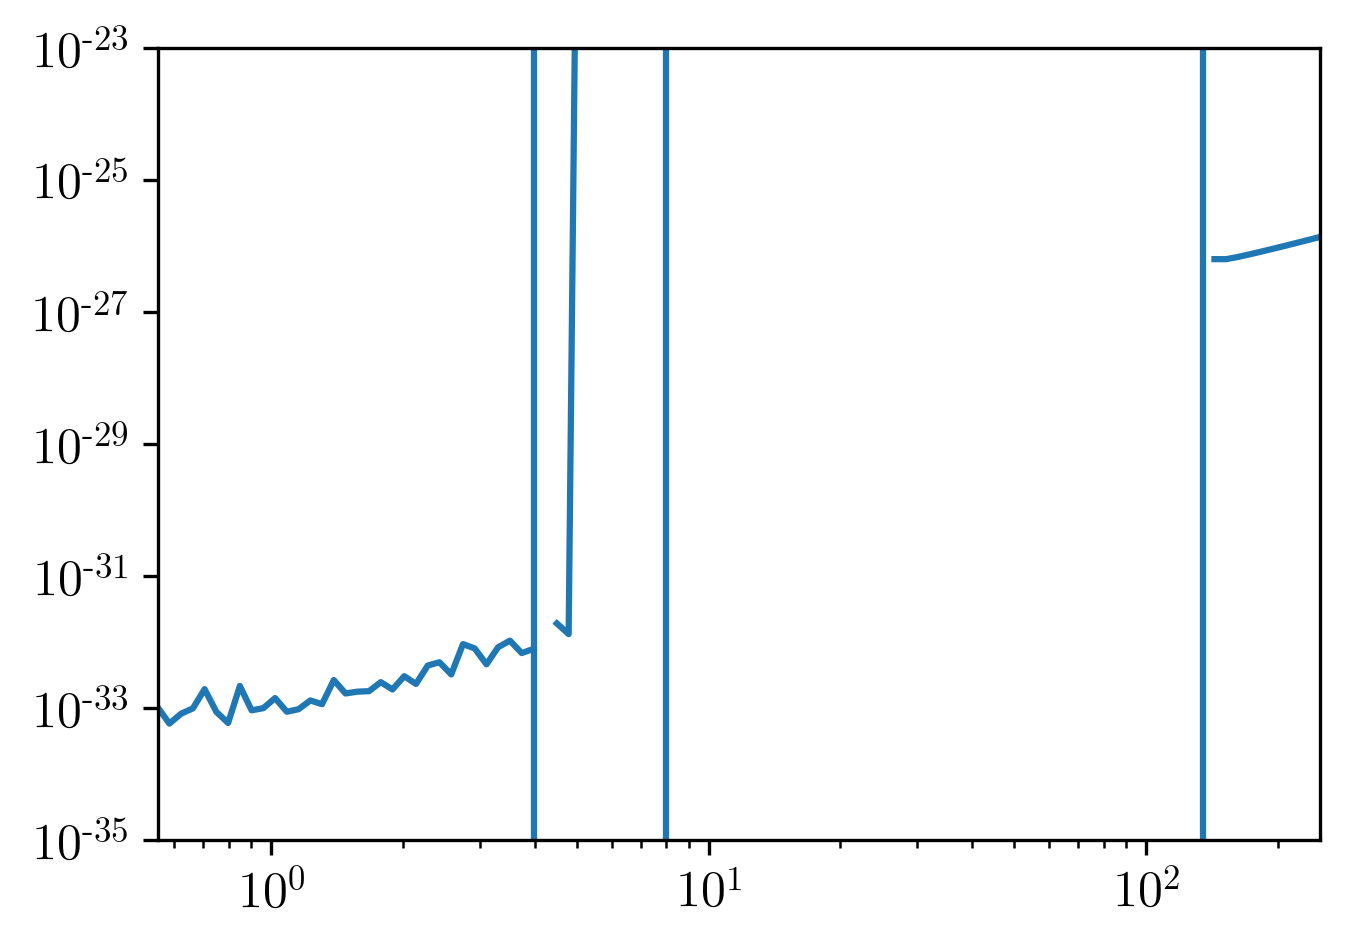

In [16]:
plt.loglog(mxs, sv_gecco)
plt.xlim(mxs[[0, -1]])
plt.ylim(1e-35, 1e-23)
plt.axvline(0.3)
plt.axvline(7.98/2)
plt.axvline(7.98)
plt.axvline(135)

# Vector

In [32]:
mvs = [200, 1000]

vm_args = np.array([
    [{"mx": 1., "mv": mv, "gvxx": 1., "eps": 0.1} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": -1, "gvss": 0.} for mv in mvs],
    [{"mx": 1., "mv": mv, "gvxx": 1., "gvuu": 1, "gvdd": 1, "gvss": 0.} for mv in mvs]
])

VMs = np.array([
    [KineticMixing, KineticMixing],
    [QuarksOnly, QuarksOnly],
    [QuarksOnly, QuarksOnly]
])

# Instantiate all the models
vms = np.vectorize(lambda VM, args: VM(**args))(VMs, vm_args)

In [33]:
# Recompute constraints
sv_constraints_vms = np.empty_like(vms)
for i in range(len(vms)):
    for j in range(len(vms[i])):
        sv_constraints_vms[i, j] = get_sv_constraints(vms[i, j], mxs)

# Save results
np.savez(
    "data/sv_constraints_vms.npz", sv_constraints_vms=sv_constraints_vms, vm_args=vm_args
)

# # Load precomputed constraints
# sv_constraints_vms = np.load(
#     "data/sv_constraints_vms.npz", allow_pickle=True
# )["sv_constraints_vms"]

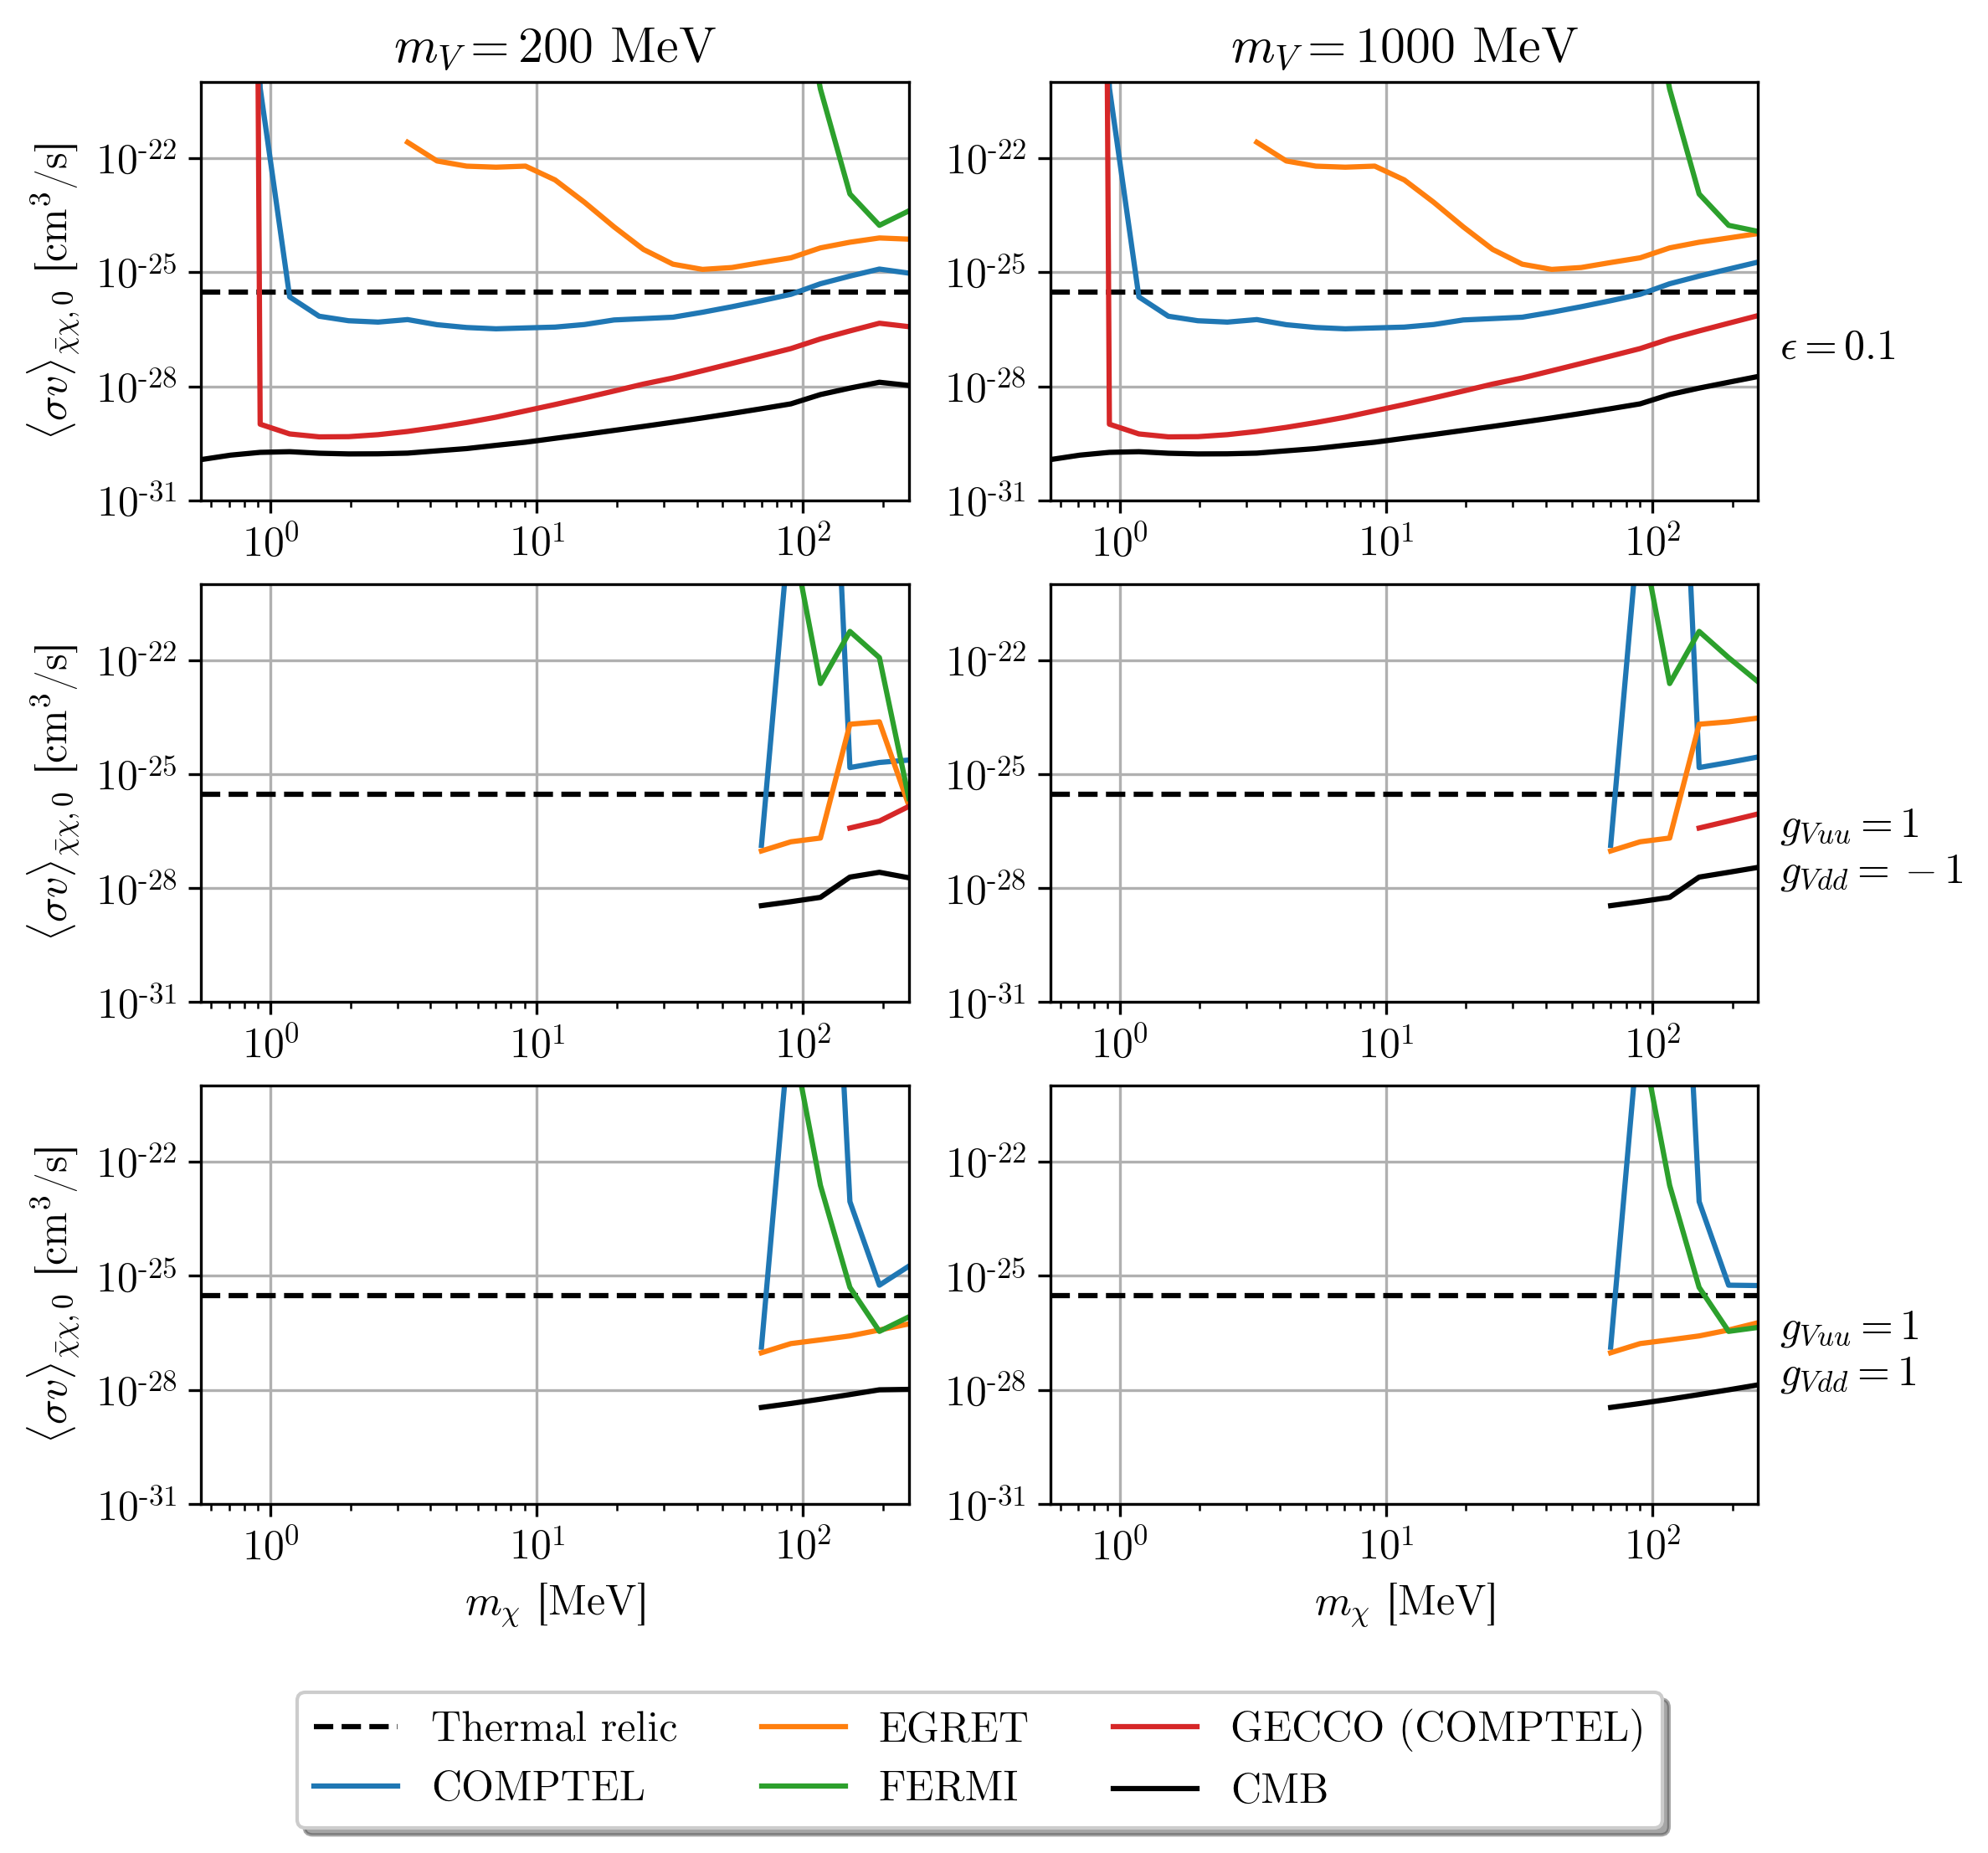

In [36]:
fig, axes = get_formatted_fig(
    *vms.shape, (4 * vms.shape[1], 2.5 * vms.shape[0]),
    mxs[[0, -1]], (1e-31, 1e-20)
)

# Current constraints
for i in range(len(axes)):
    for j in range(len(axes[i])):
        ax = axes[i, j]
        
        # Thermal relic cross section
        ax.axhline(3e-26, linestyle="--", color="k", label="Thermal relic")
        
        # Constraints
        for key, svs in sv_constraints_vms[i, j].items():
            if key in ["comptel_check", "gecco_large", "e_astrogam", 'gecco_gc', 'gecco_egret', 'gecco_fermi', 'gecco_draco']:
                continue
            elif key == "cmb":
                ax.plot(mxs, svs, "k", label=r"CMB")
            else:
                ax.plot(mxs, svs, label=get_constraint_label(key))

# Mediator mass labels
for mv, ax in zip(mvs, axes[0]):
    ax.set_title(r"$m_V = $" + f"{mv} MeV")

# Coupling labels
row_labels = [
    r"$\epsilon = %.1f$" % vms[0, -1].eps,
    r"$g_{Vuu} = %i$" % vms[1, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[1, -1].gvdd,
    r"$g_{Vuu} = %i$" % vms[2, -1].gvuu + "\n" + "$g_{Vdd} = %i$" % vms[2, -1].gvdd,
]
for label, ax in zip(row_labels, axes[:, -1]):
    ax.text(3e2, 1e-27, label, va="center")

# Put a legend below last axis
axes[-1, -1].legend(
    loc='upper center', bbox_to_anchor=(-0.1, -0.4), fancybox=True, shadow=True, ncol=3
)

fig.savefig("figures/gecco/vm_comptel.png", bbox_inches="tight")

In [38]:
T_obs_nt / 1e6

1.0

In [24]:
beeper.beep(frequency=900, secs=0.7, blocking=True)

# Debugging model-independent class

In [8]:
mx = 75
sm = HiggsPortal(mx, 1e3, 1, 0.1)
sc_pi0_g = SingleChannel(mx, "pi0 g", 1)
sc_pi_pi = SingleChannel(mx, "pi pi", 1)
sc_mu_mu = SingleChannel(mx, "mu mu", 1)
sc_e_e = SingleChannel(mx, "e e", 1)

In [9]:
e_gams = np.geomspace(5e0, 3e2, 1000)
e_cm = 2 * mx * (1 + 1e-3**2)

In [10]:
sc_pi0_g.sigma(e_cm)

1

In [11]:
sc_pi0_g.annihilation_cross_sections(e_cm)

{'pi0 g': 1, 'total': 1}

(1e-05, 1.0)

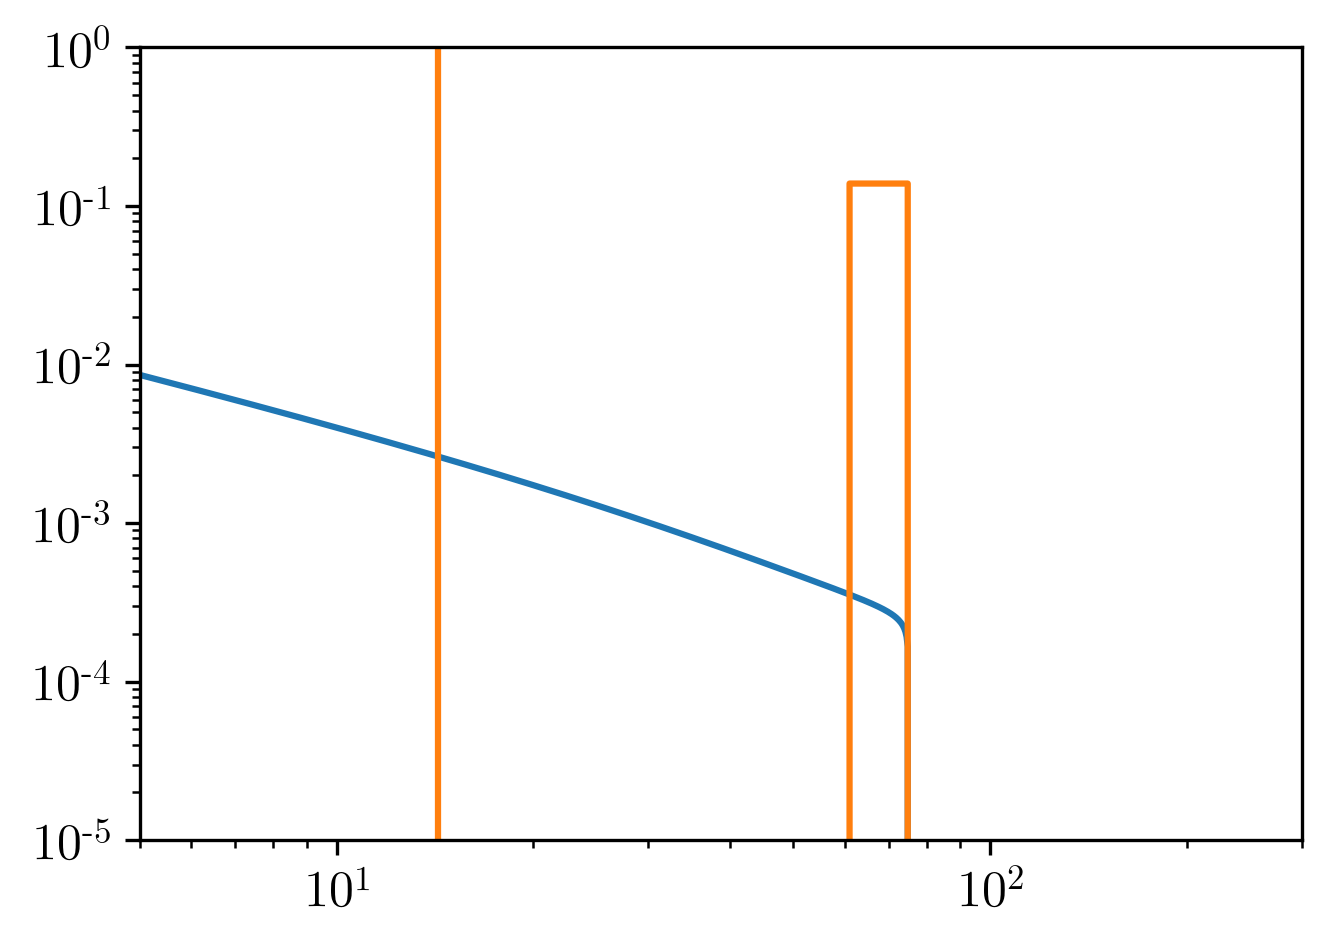

In [13]:
plt.loglog(e_gams, sm.total_spectrum(e_gams, e_cm))
# plt.loglog(e_gams, sc_pi_pi.total_spectrum(e_gams, e_cm) * 1/3 + sc_pi0_pi0.total_spectrum(e_gams, e_cm) * 1/5)
plt.loglog(e_gams, sc_pi0_g.total_spectrum(e_gams, e_cm))
try:
    plt.axvline(sc_pi0_g.gamma_ray_lines(e_cm)["pi0 g"]["energy"], color=colors[1])
except KeyError:
    pass

plt.xlim(e_gams[[0, -1]])
plt.ylim(1e-5, 1e0)

# Background models

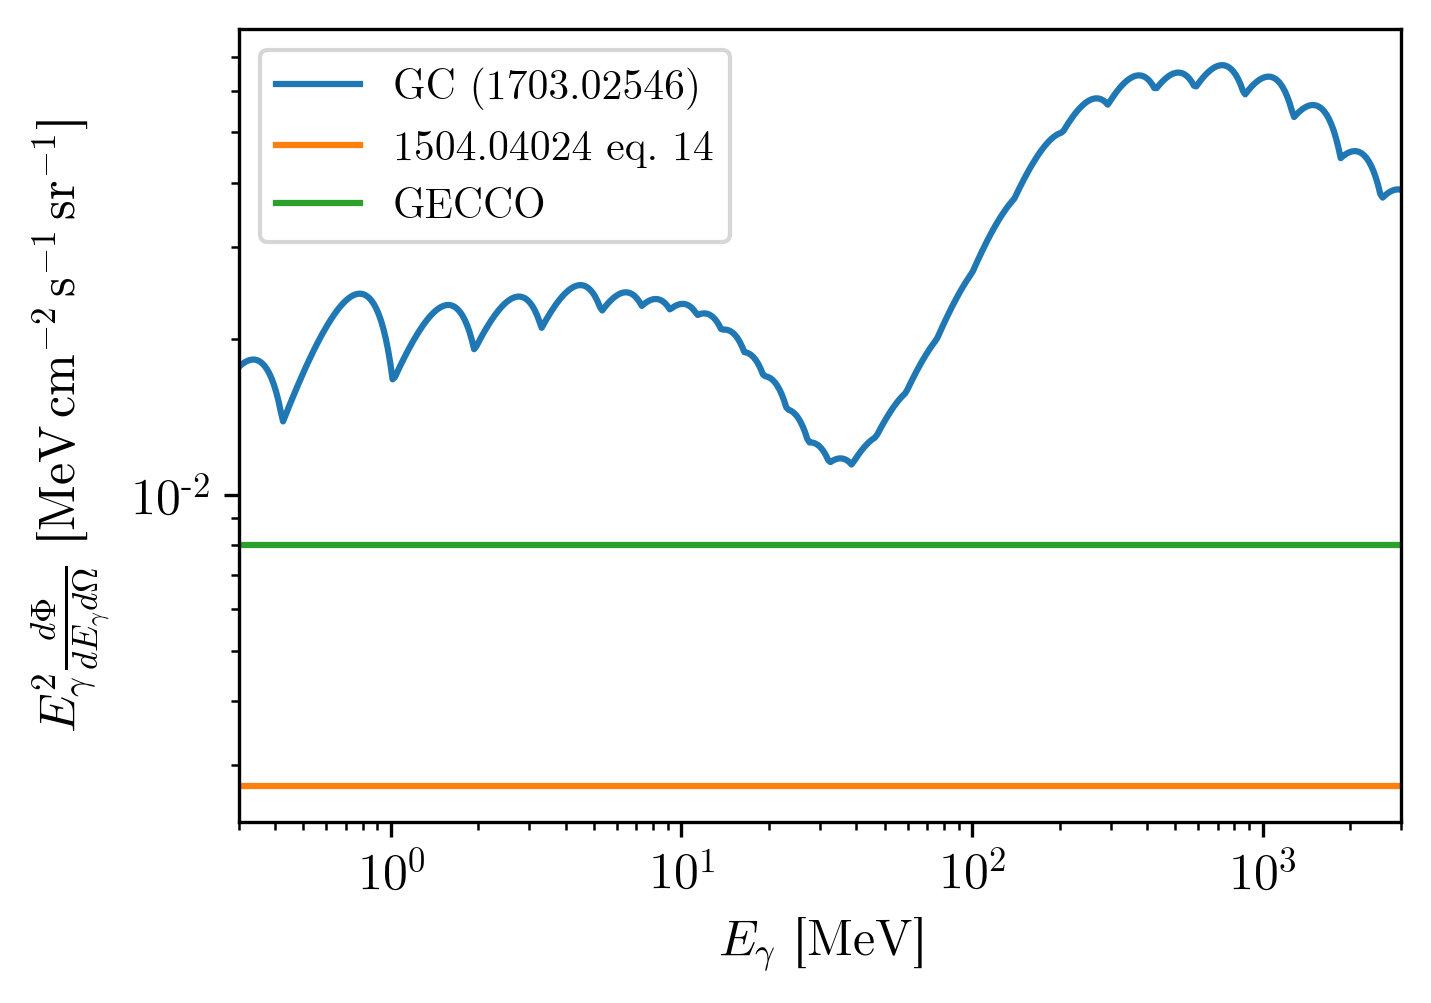

In [35]:
e_gams = np.geomspace(0.3, 3e3, 500)

plt.loglog(e_gams, e_gams**2 * gc_bg_model.dPhi_dEdOmega(e_gams), label="GC (1703.02546)")
plt.loglog(e_gams, e_gams**2 * default_bg_model.dPhi_dEdOmega(e_gams), label="1504.04024 eq. 14")
plt.loglog(e_gams, e_gams**2 * gecco_bg_model.dPhi_dEdOmega(e_gams), label="GECCO")

plt.xlim(e_gams[[0, -1]])
plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$E_\gamma^2 \frac{d\Phi}{dE_\gamma d\Omega}$ [$\mathrm{MeV} \, \mathrm{cm}^{-2} \, \mathrm{s}^{-1} \, \mathrm{sr}^{-1}$]")
plt.legend(fontsize=10)

plt.savefig("figures/gecco/bg_models.png")

# Effective areas

'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'cmunrm.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


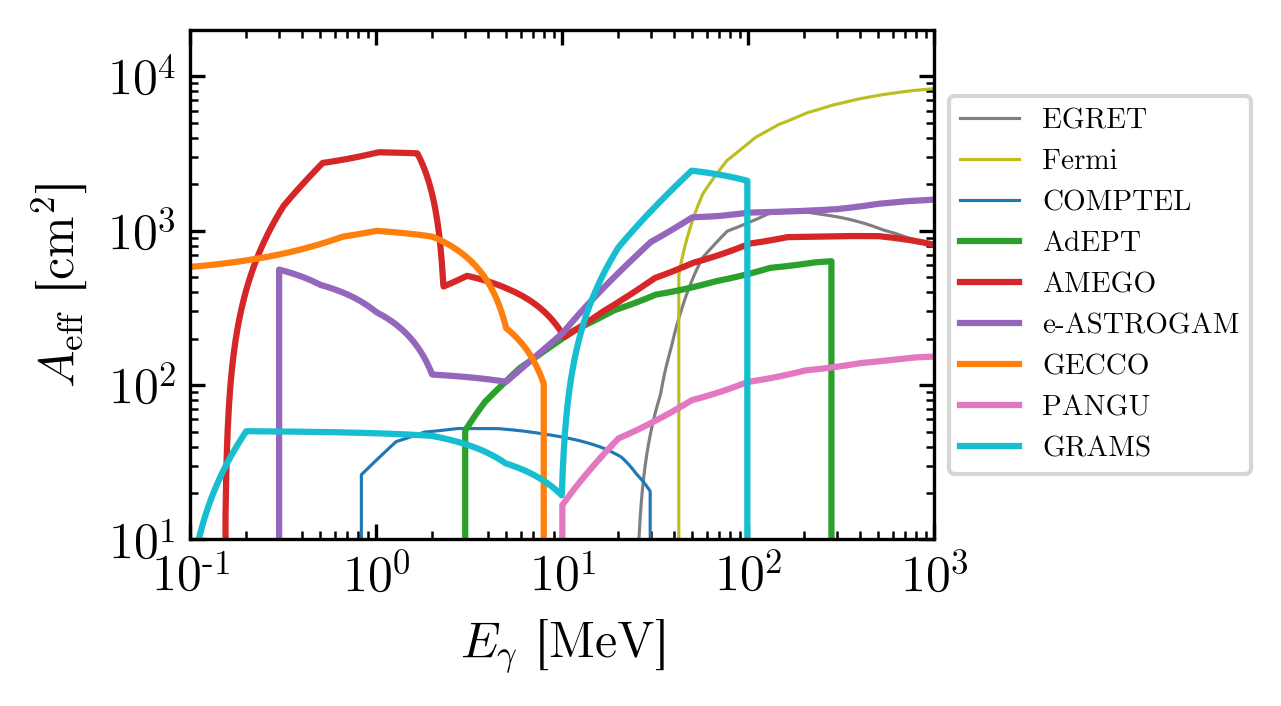

In [149]:
plt.figure(figsize=(4, 2.25))

e_gams = np.geomspace(0.1, 1e3, 2000)

plt.plot(
    e_gams, A_eff_egret(e_gams), color=telescope_colors["egret"], label="EGRET",
    linewidth=0.75
)
plt.plot(
    e_gams, A_eff_fermi(e_gams), color=telescope_colors["fermi"], label="Fermi",
    linewidth=0.75
)
plt.plot(
    e_gams, A_eff_comptel(e_gams), color=telescope_colors["comptel"], label="COMPTEL",
    linewidth=0.75
)
plt.plot(e_gams, A_eff_adept(e_gams), color=telescope_colors["adept"], label="AdEPT")
plt.plot(e_gams, A_eff_amego(e_gams), color=telescope_colors["amego"], label="AMEGO")
plt.plot(
    e_gams, A_eff_e_astrogam(e_gams), color=telescope_colors["e-astrogam"],
    label="e-ASTROGAM"
)
plt.plot(e_gams, A_eff_gecco(e_gams), color=telescope_colors["gecco"], label="GECCO")
plt.plot(e_gams, A_eff_pangu(e_gams), color=telescope_colors["pangu"], label="PANGU")
plt.plot(e_gams, A_eff_grams(e_gams), color=telescope_colors["grams"], label="GRAMS")

plt.xlim(e_gams[[0, -1]])
plt.ylim(1e1, 2e4)
plt.xscale("log")
plt.yscale("log")
plt.gca().xaxis.set_ticks_position('both')
plt.gca().yaxis.set_ticks_position('both')
plt.gca().tick_params(axis='both', which='both', direction="in")
plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$A_\mathrm{eff}$ [cm$^2$]")

box = plt.gca().get_position()
plt.gca().set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)

plt.savefig("figures/a_effs.pdf", bbox_inches="tight")

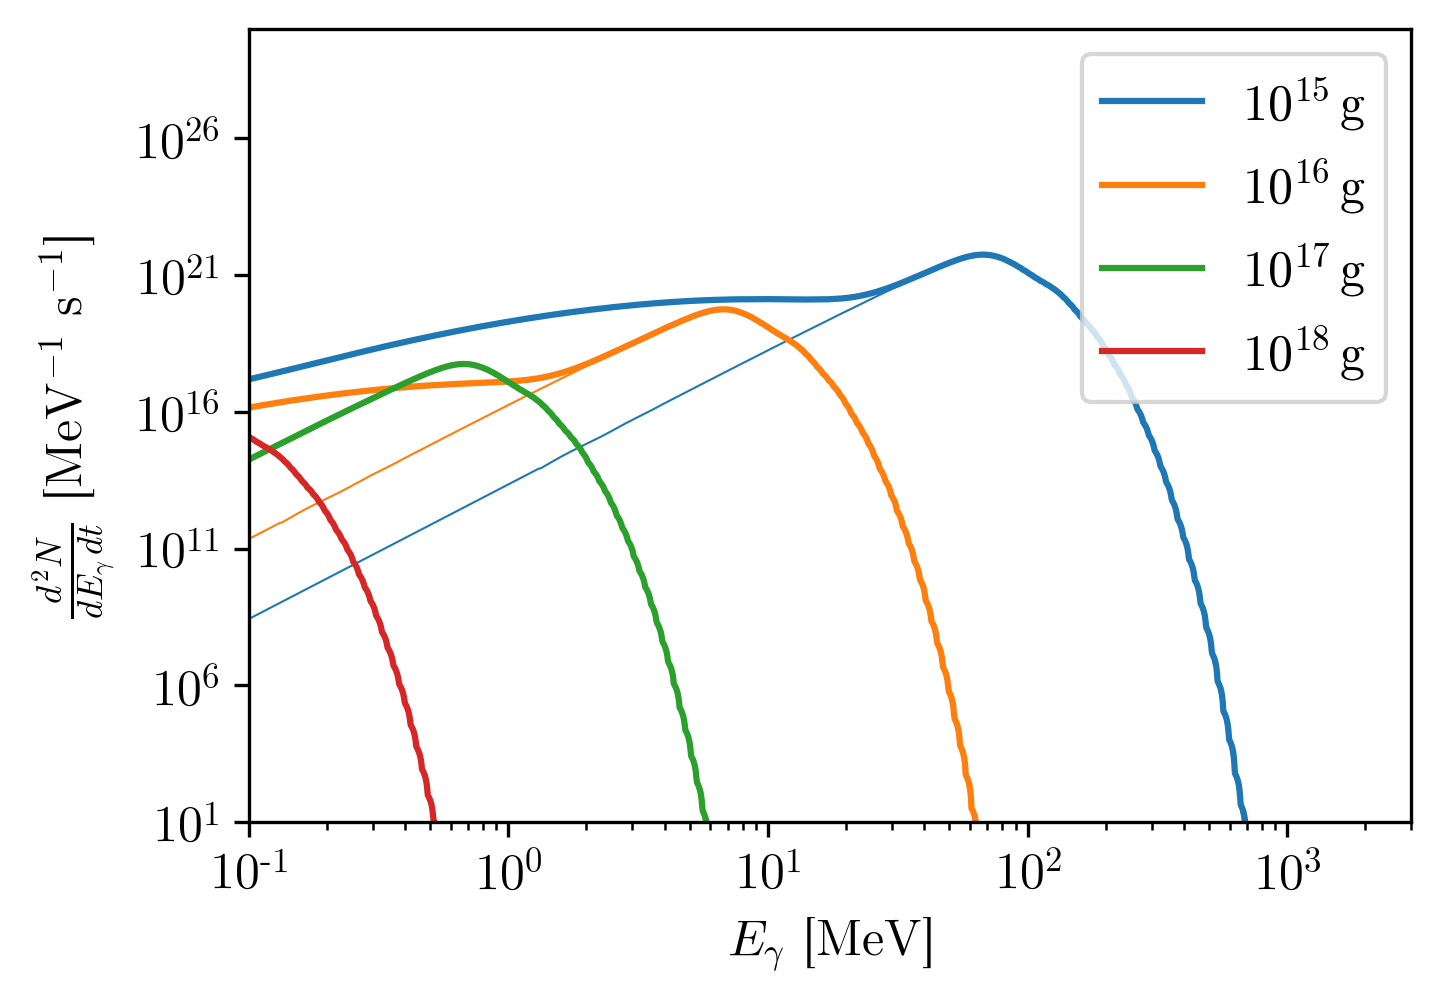

In [59]:
mxs = np.geomspace(1e15, 1e18, 61) * g_to_MeV

for mx, color in zip(mxs[::20], mpl_colors):
    pbh_sec = PBH(mx, spectrum_kind="secondary")
    ax.loglog(
        e_gams,
        e_gams**2 * pbh_sec.total_spectrum(e_gams),
        color=color,
        linewidth=0.5,
    )
    pbh_prim = PBH(mx, spectrum_kind="primary")
    ax.loglog(
        e_gams,
        e_gams**2 * pbh_prim.total_spectrum(e_gams),
        color=color,
        label=r"$10^{%i}\, \mathrm{g}$" % int(np.log10(mx * MeV_to_g))
    )

ax.set_xlim(e_gams[[0, -1]])
ax.set_ylim(1e1, 1e30)
ax.set_xlabel(r"$E_\gamma$ [MeV]")
ax.set_ylabel(r"$\frac{d^2N}{dE_\gamma\, dt}$ [MeV$^{-1}$ s$^{-1}$]")
plt.legend()

In [ ]:
# # Energy resolutions
# plt.subplot(1, 2, 2)
# plt.plot(A_eff_adept.x, 100 * energy_res_adept(A_eff_adept.x), "--", label="AdEPT")
# plt.plot(energy_res_amego.x, 100 * energy_res_amego.y, "--", label="AMEGO")
# plt.plot(A_eff_comptel.x, 100 * energy_res_comptel(A_eff_comptel.x), label="COMPTEL")
# plt.plot(
#     energy_res_e_astrogam.x, 100 * energy_res_e_astrogam.y,
#     "--", label="e-ASTROGAM"
# )
# plt.plot(A_eff_egret.x, 100 * energy_res_egret(A_eff_egret.x), label="EGRET")
# plt.plot(A_eff_fermi.x, 100 * energy_res_fermi(A_eff_fermi.x), label="Fermi")
# plt.plot(energy_res_gecco.x, 100 * energy_res_gecco.y, "--", label="GECCO")
# plt.plot(energy_res_mast.x, 100 * energy_res_mast.y, "--", label="MAST")
# plt.plot(A_eff_pangu.x, 100 * energy_res_pangu(A_eff_pangu.x), "--", label="PANGU")

# plt.xlabel(r"$E_\gamma$ [MeV]")
# plt.ylabel(r"$\Delta E / E$ (%)")
# plt.xlim(e_gams[[0, -1]])
# plt.ylim(0, 50)
# plt.xscale("log")

# Energy resolution

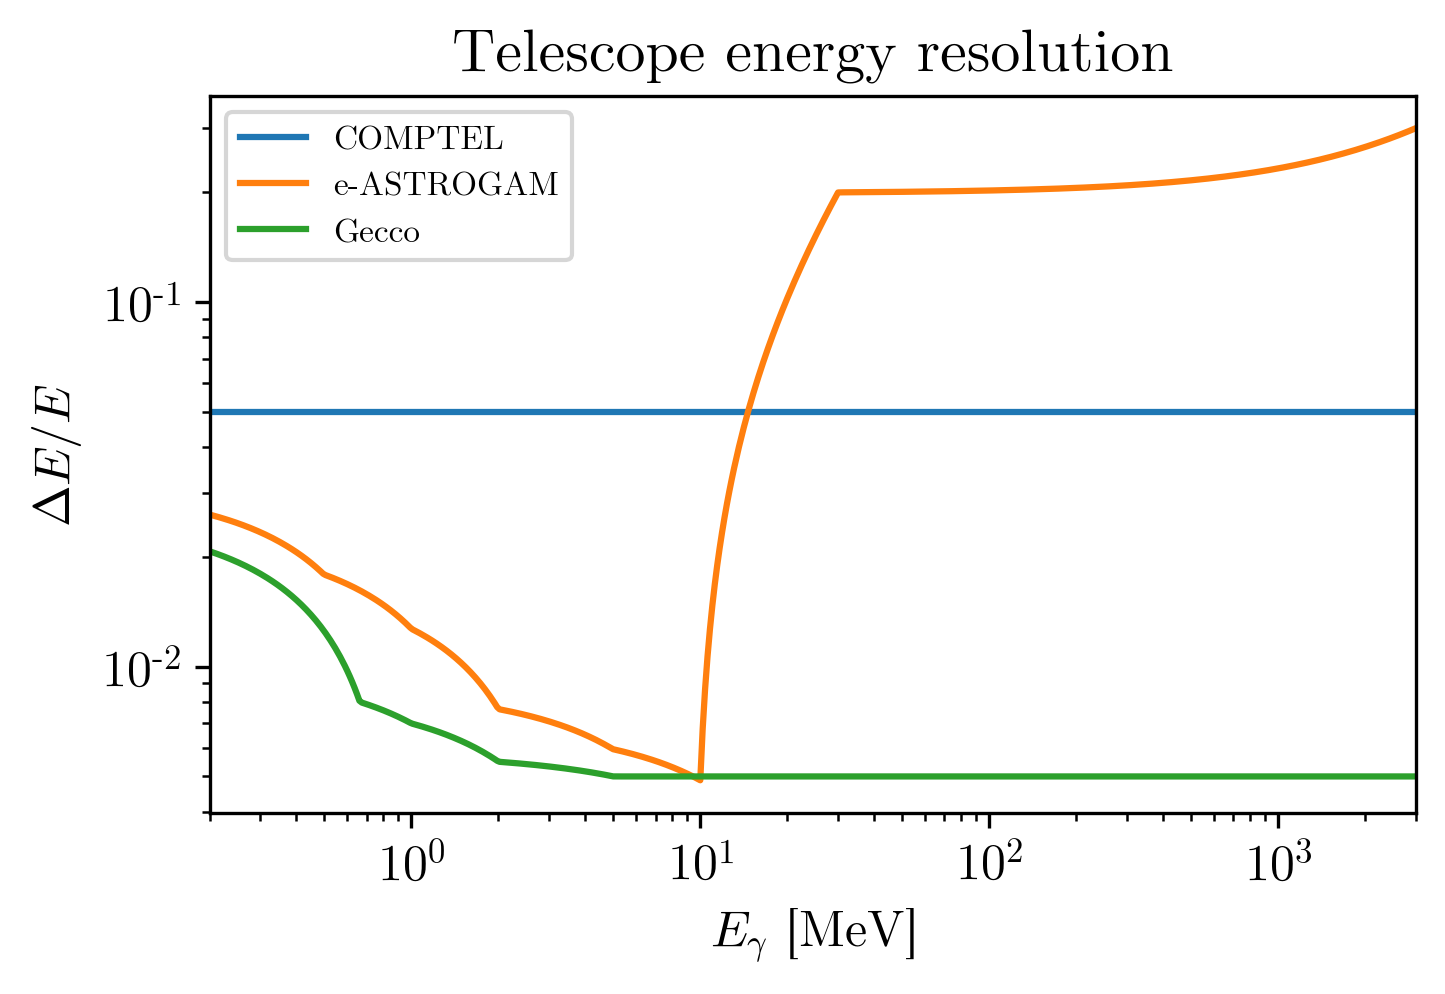

In [32]:
e_gams = np.geomspace(0.2, 3e3, 500)

plt.plot(e_gams, energy_res_comptel(e_gams) * np.ones(len(e_gams)), label="COMPTEL")
plt.plot(e_gams, energy_res_e_astrogam(e_gams), label="e-ASTROGAM")
plt.plot(e_gams, energy_res_gecco(e_gams), label="Gecco")

plt.xlabel(r"$E_\gamma$ [MeV]")
plt.ylabel(r"$\Delta E / E$")
plt.xlim(e_gams[[0, -1]])
# plt.ylim(1e1, 1e4)
plt.xscale("log")
plt.yscale("log")
plt.legend(fontsize=8)
plt.title("Telescope energy resolution")

plt.tight_layout()
plt.savefig("figures/gecco/energy_res.png")